# Test détection de signature 

<font color = 'red'> **Kernel pdf** </font>
    
**Notes sur l'installation des librairies**

**pdf2image**:\
Pour lire un pdf avec OpenCv il faut d'abord le transformer en jpg ou jpeg avec la fonction `convert_from_path` de la librairie `pdf2image`
(doc: https://stackoverflow.com/questions/61832964/how-to-convert-pdf-into-image-readable-by-opencv-python).
Cependant, pour pouvoir utiliser `convert_from_path`, il faut installer `poppler` pour Windows en suivant le lien https://github.com/oschwartz10612/poppler-windows/releases/ (lien indiqué dans le tuto : https://github.com/Belval/pdf2image).

Une fois sur site indiqué par le lien de téléchargement, cliquer sur la version `Release-23.01.0-0.zip` et placer le téléchargement dans le répertoire de votre choix. Dé-zipper le dossier intitulé `poppler-23.01.0` et créer une variable `poppler_path` qui vaut: `chemin du répertoire poppler-23.01.0\\Library\\bin`. Par exemple, j'ai placé mon dossier `poppler-23.01.0` dans le répertoire `utilities` défini par le chemin `C:\Users\A3193307\Groupe BPCE\CEMP - Data & Décisionnel - Data Science\Analyse Documents\1_Programme_Lila\utilities`. Ainsi ma variable `poppler_path` vaudra : `poppler_path  = "C:\\Users\\A3193307\\Groupe BPCE\\CEMP - Data & Décisionnel - Data Science\\Analyse Documents\\1_Programme_Lila\\utilities\\poppler-23.01.0\\Library\\bin"` (penser à doubler les `\` pour python).


**signature-detect**:\
J'ai installé le package `signature-detect` (tuto: https://github.com/EnzoSeason/signature_detection/blob/main/demo.ipynb) avec pip sans problème mais ensuite, ce package utilisait `ImageMagick` que je n'ai pas pu installer car l'ordi de la banque me le bloquait. Donc au final, j'ai regardé plus en détail le package `signature-detect` et j'ai vu qu'il utilisait `ImageMagick` seulement pour transformer les pdfs en images dans le cas où on lui rentre un pdf. Donc j'ai copié tout le package `signature-detect` et retiré toutes les fonctions concernant les pdfs et donc maintenant j'utilise mon package `signature-detect` customisé qui n'a plus besoin de `ImageMagick`. En revanche, il faut donc fournir en entrée une image et donc au préalable avoir transformé les pdfs en image (jpg ou jpeg) avec `pdf2image`.


**Tesseract**:\

Il faut installer Tesseract OCR sur la machine (https://codetoprosper.com/tesseract-ocr-for-windows/). Dans mon cas, Tesseract est installé ici :  `C:\Program Files\Tesseract-OCR`. Puis on installe ensuite l'extension python de tesseract avec la commande `pip install pytesseract` et `pip install tesseract`. J'obtiens à présent l'erreur suivante : *tesseract is not installed or it's not in your PATH. See README file for more information*. Il faut donc définir le chemin du tesseract dans le script avant d'appeler image_to_string :
`pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'` (source: https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i)


In [55]:
# Variables globales & chemins absolus
# ------------------------------------
#----- Chemin du répertoire de travail
PATH = "C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila"

#----- Chemin des données
PATH_DATA = PATH + "/data"
# document LEA
PATH_DATA_LEA_P = PATH_DATA + "/LEA/papier" #signatures papiers
PATH_DATA_LEA_N = PATH_DATA + "/LEA/numerique" #signatures numériques
# document EAI
PATH_DATA_EAI_P = PATH_DATA + "/EAI/papier" #signatures papiers
PATH_DATA_EAI_N = PATH_DATA + "/EAI/numerique" #signatures numériques

#----- Chemin des scripts python .py
PATH_UTILS =  PATH + "/utilities"
poppler_path  = PATH_UTILS +'/poppler-23.01.0/Library/bin'

In [56]:
# Librairies nécessaires
# ------------------------------------
#---- Système
import os
import sys #affichage barre progression
import time

#---- Calculs 
import numpy as np
import math
import pandas as pd

#---- Graphes 
import matplotlib.pyplot as plt

#---- Traitement des PDFs
import PyPDF2 #traitement des pdf
import cv2 #traitement d'image (jpg)
import PIL #traitement d'image (jpg)
from pdf2image import convert_from_path #transformation pdf en jpg

#---- signature-detect
os.chdir(PATH_UTILS) #signature_detect est dans le dossier utilities
#from signature_detect.loader import Loader
#from signature_detect.extractor_v2 import Extractor ###
from signature_detect.cropper import Cropper
from signature_detect.judger import Judger

#---- supprimer les bords noirs des images 
"""
from skimage.filters import threshold_local
import argparse
import imutils
"""
#----- Détection de texte avec Tesseract
import pytesseract
#Set the tesseract path in the script before calling image_to_string:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

import re #recherche dans le texte
import unicodedata #retirer les accents d'un texte
from difflib import SequenceMatcher #calcul de similarité entre 2 textes 

#----- Sauvegarde 
import pickle 
import csv

# excel : pip install openpyxl

## LEA

### Notes

On commence par la détection de signature sur les documents LEA scannés. Nous aurons un traitement différent si le document a été scanné ou si la signature est électronique. En effet, dans le cas des signatures électroniques, la signature est trop petite pour être détectée par l'algorithme.

Les documents LEA n'ont pas un nombre de pages fixe. La signature se situe sur la dernière page du document. Cependant, il faudra  identifier au préalable la page contenant la signature car il ne s'agit pas toujours de la dernière page selon comment le document a été scanné (par exemple, identifier avec tesseract un texte "Signature" pour identifier la page présentant la signature).

Attention, il se peut que des documents soient scannés à l'envers. Il faudra trouver un moyen d'identifier ces cas et de les corriger. 
_________________________
_________________________
1) certaines images ne sont pas bien débruitées donc le mask est cahotique : C'est bon j'ai débruité l'image auparavant et donc on utilie plus Loader de signature-detect mais une autre fonction qui me débruite l'image.

2) il y a 2 signature dans l'image, il faut arriver à n'en détecter qu'une : OK j'ai crop l'image ce qui permet de ne détecter que une signature mais aussi ne mieux détecter la signature.

3) il faut peut-être retirer les lignes verticales et horizontales, sinon, l'algo trouve le cadre et ne détecte pas la signature. On veut pouvoir supprimer le cadre: Avec les étapes 1 et 2 plus besoin

4) Ne détecte pas les signatures trop petites qui correspondent souvent à des signatures électroniques.

5) dans le cas où il n'y a pas d'image, la variable `results` à une longueur de 0 et donc signature ne fonctionne pas. Mais si results est nulle alors on peut se dire que il n'y a pas de signature. Il faut donc juste ajouter un `if`.

_________________________
_________________________
le 007015026 est une signature électronique très petite et donc ça ne prend pas en compte la signature. Par contre, quand j'ai récupéré le pdf, il y avait marqué "signature papier". Donc peut-être qu'il me faudra une méthode différente pour la signature papier et la signature électronique et que ma méthode puisse différencier si le pdf est signé papier ou numériquement.
Après vérif, toutes les signatures électroniques sont petites. 

sur le 007333320, je crois qu'ils ont échangé signature de la banque et signature client. Je ne pourrai pas faire la différence pour le moment. -> Oui mais c'est pas si grave car si la banque a signé c'est bien que le client a signé je pense.

Pour le 007417781, la signature n'est pas dans l'onglet "signature du titulaire" mais dans l'onglet "signature du représentant légal en précisant nom et prénom". Donc attentien à bien prendre un cadre qui prend en compte les 2 encadrés. \
En plus, le pdf a été scanné à l'envers, donc la dernière page est la première est vice-versa donc au lieu de prendre la dernière page, il faudrait avec tesseract arriver à déterminer la page signature, là où il y a marqué "Signature" car il se peut que ce ne soit pas le seul pdf dans ce cas.

détection de contours ne marche pas sur 007308023 car les contours ne sont pas assez bien définis, même si je débruite l'image et qu'nsuite je fait une erosion pour foncer les contours, ils ne sont toujours pas bien définis car la signature présente elle même des lignes verticales qu'il détecte comme des contours. Donc on peut faire un système de vote : détection de la signature en ayant détecté le contour au préalable et en ayant recadré l'image.

Pour le pdf 007333320, tesseract arrive pas à lire signature du titulaire car la signature recouvre une partie du texte.
_________________________
_________________________

OpenCv text détection : https://pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

Detect Roated page in pdf : https://stackoverflow.com/questions/34515674/how-to-detect-a-rotated-page-in-a-pdf-document-in-python. Ca n'a pas l'air facile en fait. Mon idée est d'essayer de lire le texte avec Tesseract. Si ce que je lis n'est pas intelligible, essayer de rotationer la page et de lire le texte à nouveau. 

Autre librairie pour détecter les signatures : https://morioh.com/p/944003547b6c. Ca détecte les pixels qui se suivent donc ne vas pas détecter les signatures écrites espacées. Mais je peux peut-être l'utiliser comme autre méthode pour faire un vote.  

_________________________
_________________________

Pour avoir une meilleure détection, il faudrait arriver à couper la moitié de la page qui ne contient pas la signature. Cependant si j'ai un pdf scanné à l'envers, je vais supprimer la partie d'intéret. 

Donc:\
étape 1): voir si le pdf a été rotationé à 90 degrés en comparant largueur et longueur. Si oui, rotationner le pdf (peu importe si au final il se situe ou non dans le bon sens ou à 180 degrès)\
étape 2): découper l'image en 2 et calculer quelle zone est la plus remplie (= contient le plus de pixels noirs). Supprimer la zone la moins remplie. 


Autre méthode : détecter le texte avec OpenCv et/ou Tesseract, puis le supprimer

text detection with openCV : 
https://itsourcecode.com/free-projects/python-projects/opencv-python-text-detection-with-source-code/
(we have to download a pre-trained model)

### Chargement pdf

In [57]:
# Récupération du jeu de donnée
# ------------------------------------
def load_pdf(pdf_name,pdf_path,poppler_path):
    """
    Cette fonction permet de charger le pdf au format
    PIL.PpmImagePlugin.PpmImageFile.

    Input:
    -----
    - pdf_name (string): nom du pdf (avec l'extension). 
      Ex: si on a 123.pdf alors pdf_name='123.pdf'.
    - pdf_path (string): chemin du pdf 
    - poppler_path (string): chemin du poppler     

    Ouput:
    -----
    - pages (liste de PIL.PpmImagePlugin.PpmImageFile): liste 
      contenant les pages du pdf.   

    ========================= Notes ==========================
    Nous aurons besoin par la suite d'utiliser la librairie OpenCv. 
    Or, pour lire un pdf avec OpenCv il faut d'abord le transformer en jpg ou jpeg avec la 
    fonction convert_from_path de la librairie pdf2image 
    (doc: https://stackoverflow.com/questions/61832964/how-to-convert-pdf-into-image-readable-by-opencv-python). 
    Cependant, pour pouvoir utiliser convert_from_path, il faut installer poppler pour Windows en suivant 
    le lien https://github.com/oschwartz10612/poppler-windows/releases/ 
    (lien indiqué dans le tuto : https://github.com/Belval/pdf2image).

    Une fois sur site indiqué par le lien de téléchargement, cliquer sur la version 
    Release-23.01.0-0.zip et placer le téléchargement dans le répertoire de votre choix. 
    Dé-zipper le dossier intitulé poppler-23.01.0 et créer une variable poppler_path qui vaut: 
    chemin du répertoire poppler-23.01.0\\Library\\bin. 
    Par exemple, j'ai placé mon dossier poppler-23.01.0 dans le répertoire utilities défini par le chemin :
    C:\\Users\\AXXXXX\\Destop\\utilities.
    Ainsi ma variable poppler_path vaudra : 
    poppler_path  = "C:\\Users\\AXXXXX\\Destop\\utilities\\poppler-23.01.0\\Library\\bin" 
    (penser à doubler les \ pour python).
    ==========================================================
    """
    # On se place dans le dossier des pdfs 
    #os.chdir(pdf_path) 
    # Récupération des pages du pdf
    pages = convert_from_path(pdf_path + "/" + pdf_name, poppler_path=poppler_path)    
    return pages

In [58]:
def show_image(img):
    """
    Cette fonction permet d'afficher une image sous forme 
    d'un graphique matplotlib.
    
    Input:
    -----
    - img (PIL.PpmImagePlugin.PpmImageFile OU np.array): image à afficher
    
    Output:
    ------
    - Graphique de l'image.    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

<font color = 'red'> Estimation du bruit de l'image pour avoir un degré de confiance de la détecrtion ?
    
<font color = 'red'> A la fin, construire un argument parser.

### Pre-processing pour l'OCR

Il est préférable d'effectuer un pre-processing de l'imge avant d'appliquer l'OCR : https://nanonets.com/blog/ocr-with-tesseract/

#### find_page_with_number()

In [59]:
def find_page_with_number(pdf,numero_page):
    """
    Cette fonction simple prend en entrée un pdf et 
    un numéro de page et renvoie l'image du pdf associée au
    numéro de page.
    
    Input:
    ------
    - pdf (liste de PIL.PpmImagePlugin.PpmImageFile): ensemble des pages du pdf
    - numero_page (int) : numéro de page. ATTENTION, la première page a le numéro 0.
      Le numéro -1 permet d'accéder à la dernière page du pdf.
    
    Output:
    ------
    - im (np.array): image correspondant au n° de page spécifié en entrée
    """
    
    im = pdf[numero_page]
    return np.array(im)

In [60]:
path_data = PATH_DATA_LEA_P
#path_data = "C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila/Alteryx/Workflow_LEA\input_data"

os.chdir(path_data) 
!ls

006061477_black_contour.PNG
006061477_black_contour_small.PNG
006956080.pdf
006956080_removed.pdf
006961477.pdf
006969920.pdf
007308023.pdf
007325270.pdf
007333320.pdf
007417781.pdf
007418530.pdf
007538249.PNG
007538249.pdf
007538249_truncated_1.pdf
007538249_truncated_2.pdf
008120289.PNG
008120289.pdf
008120289_perspective_1.pdf
008120289_perspective_2.pdf
008120289_rotated_180.pdf
008120289_rotated_30.pdf
008120289_rotated_70.pdf
008120289_rotated_90.pdf
Nouveau Document Microsoft Word.docx
test.xlsx


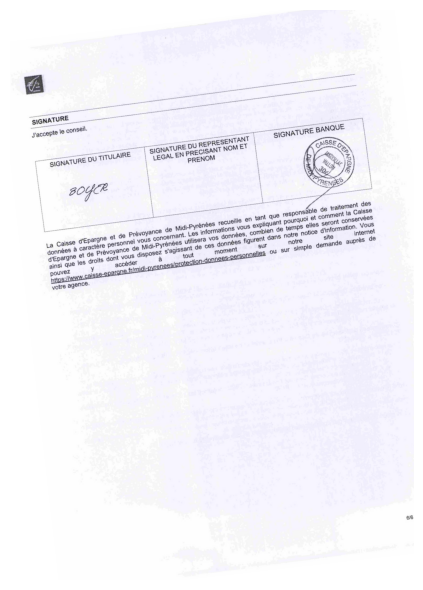

In [61]:
pdf = load_pdf("008120289_rotated_30.pdf",path_data,poppler_path)
im = find_page_with_number(pdf,-1)
show_image(im)

In [ ]:
"""pdf = load_pdf("template_eai_type3.pdf",PATH,poppler_path)
im = np.array(pdf[1])
from PIL import Image
pil_im = Image.fromarray(im)
pil_im.save("alteryx_template_eai_type3.pdf")"""

#### Rotation de l'image

In [62]:
def get_angle_openCV(img,thresh=300):
    """
    Cette fonction permet de calculer l'angle de rotation d'une image 
    uniquement à l'aide de la librairie OpenCV. 
    L'avantage de cette méthode est qu'elle permet de détecter tous les 
    angles re rotation de l'image, et pas seulement les angles 90° et 180°.
    Le désaventage est que cette méthode n'est pas capable de faire la 
    différence entre un angle de 0° et un angle de 180°.

    Input:
    -----
    - im (np.array): image à rotationer.
    - thresh (int): lors de l'extraction des lignes avec HoughLinesP, seules sont renvoyées 
      les lignes qui ont obtenu suffisamment de votes (> thresh).

    Output:
    -------
    - median_angle (float): médiane de tous les angles de l'image.

    ============================= Notes =============================
    La méthode consiste à extraire les contours de l'image avec cv2.Canny et 
    extraire les lignes principales de l'image avec cv2.HoughLinesP. 
    On itère sur chaque ligne et on calcule l'angle entre chaque ligne
    et l'horizontale avec math.atan2. On obtient une liste d'angles.
    On calcule l'angle médian. 

    L'équation normale d'une droite est r = x*cos(w) + y*sin(w) où r est la distance
    perpendiculaire entre l'origine et la ligne et w est l'angle en radians
    entre la ligne perpendiculaire et l'axe horizontal. 

    Si on pose a = cos(w) et b = sin(w) alors a^2 + b^2 = 1.
    De plus, r = x*a+y*b => y = (r-x*a)/b. Avec cette dernière equation, on peut
    trouver les coordonées de n'importe quel point de la droite.

    Ainsi si on par exemple prend x1 = a*r + c*b (où c est une constante)
    alors y1 = (r-x1*a)/b = (r-(a*r + c*b)*a)/b = (r - a^2*r)/b + a*c
    = r(1-a^2)/b + a*c or 1 = a^2 + b^2  donc y1 =  rb + a*c.
    ================================================================
    
     Reference:
    ----------
    - site dont est tiré ce code :
      https://stackoverflow.com/questions/55119504/is-it-possible-to-check-orientation-of-an-image-before-passing-it-through-pytess
    - Normal form line equation :
      https://math.stackexchange.com/questions/2882903/how-can-i-plot-a-straight-line-which-is-in-normal-form
    - Différence entre HoughLines et HoughLinesP :
      https://rsdharra.com/blog/lesson/14.html
    - Documentation HoughLines et HoughLinesP :
      https://docs.opencv.org/3.4/d3/de6/tutorial_js_houghlines.html
    - calcul des angles : 
      https://stackoverflow.com/questions/42258637/how-to-know-the-angle-between-two-vectors/42258870#42258870
    - rotation d'une image selon ses lignes horizontales
      https://stackoverflow.com/questions/39752235/python-how-to-detect-vertical-and-horizontal-lines-in-an-image-with-houghlines-w
      https://stackoverflow.com/questions/67684060/rotate-image-to-align-features-with-x-axis-in-opencv-python      
    """
    
    # Trouve les bords de l'image
    # Permet aussi de s'assurer d'avoir une image binaire pour cv2.HoughLines
    edges = cv2.Canny(img, 50, 150, apertureSize = 3)

    # HoughLines: Transform used to detect straight lines.
    lines = cv2.HoughLines(image=edges, rho=1, theta=np.pi/180, threshold=thresh)
    #Seules sont renvoyées les lignes qui ont obtenu suffisamment de votes (>thresh).
    #lines = liste ou chaque élément de la liste vaut: [[rho,theta]] où rho est la distance
    #perpendiculaire en pixels entre l'origine et la ligne et theta est l'angle en radians
    #entre la ligne perpendiculaire et l'axe horizontal. Il s'agit d'une équation de droite
    #sous la forme normale.

    angles = []

    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        
        radians = np.arctan2(y2-y1, x2-x1)
        degrees = np.degrees(radians)

        angles.append(degrees)
        
    median_angle = np.median(angles)

    return median_angle
    
def get_angle_tesseract(im,orientation_conf=5):
    """
    Cette fonction permet de calculer l'angle de rotation d'une image 
    uniquement à l'aide de la librairie Tesseract. 
    Néamoins, cette méthode n'est capable de détecter que les images 
    rotationées à 90° ou à 180°.
    En revanche, l'algorithme fait bien la différence entre une image 
    rotationée à 0° et une image rotationée à 180°. 
    Si le niveau de confiance renvoyépar tesseract
    est < orientation_conf, alors l'image n'est pas rotationée.
    
    Input:
    -----
    - im (np.array): image à rotationer.
    - orientation_conf (float): niveau de confiance renvoyée par tesseract
      quant à la précision de la prédiction de l'orientation du texte. 
      Je considère que orientation_conf >=5 ou 6 donne des résultats 
      plutôts corrects.
    
    Output:
    -------
    - angle (float): angle principal de l'image.
    
    ===================== Notes =====================
    Une méthode consiste donc à appliquer d'abord la fonction 
    get_angle_openCV() pour tourner l'image de l'angle trouvé.
    Cette fonction ne fait pas la différence entre une image 
    tournée à 0° et une image tournée à 180°.
    Donc on applique ensuite la fonction get_angle_tesseract() 
    pour tourner l'image à 0° dans le cas où celle-ci serait à 180°.
    =================================================
    
    Reference:
    ---------
    - Détecter si l'image est rotationée avec Tesseract :
      https://pyimagesearch.com/2022/01/31/correcting-text-orientation-with-tesseract-and-python/
      https://stackoverflow.com/questions/55119504/is-it-possible-to-check-orientation-of-an-image-before-passing-it-through-pytess
    """
    
    osd = pytesseract.image_to_osd(im,output_type=pytesseract.Output.DICT)
    
    if osd['orientation_conf'] >= orientation_conf:
        angle = osd['orientation']
    else : 
        angle = 0
    return angle

    
def rotate_im(image, angle):
    """
    Cette fonction permet de rotationner une image 
    d'un certain angle, sans ronger les contours lors
    de la rotation.
    ATTENTION : si l'image est binaire, la sortie im_rot
    ne sera plus bianire car la rotation "dé-binarise" 
    l'image.
    
    Input:
    -----
    - image (np.array): image à rotartionner
    - angle (float): angle en dregrés de la rotation.
    
    Output:
    -------
    - im_rot (np.array): image rotationée correctement.
    
    Reference:
    ----------
    - rotation "correcte" de l'image:
      https://pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    """
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix, then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    im_rot = cv2.warpAffine(image, M, (nW, nH), borderValue=(255,255,255),
                            flags = cv2.INTER_NEAREST, borderMode = cv2.BORDER_CONSTANT)
    return im_rot

Image avant toute modification


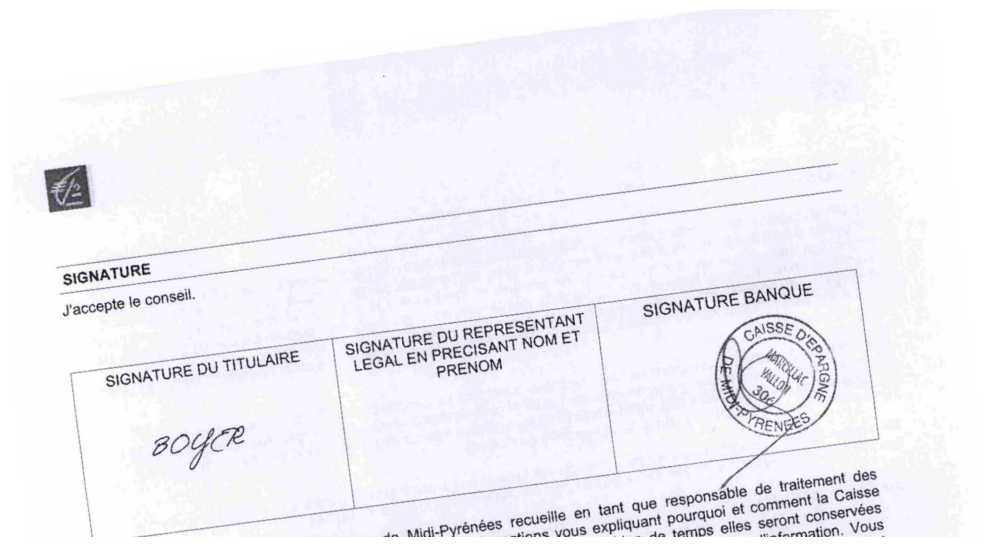

angle OpenCV:  -7.9963002674811845
Image après rotation OpenCV


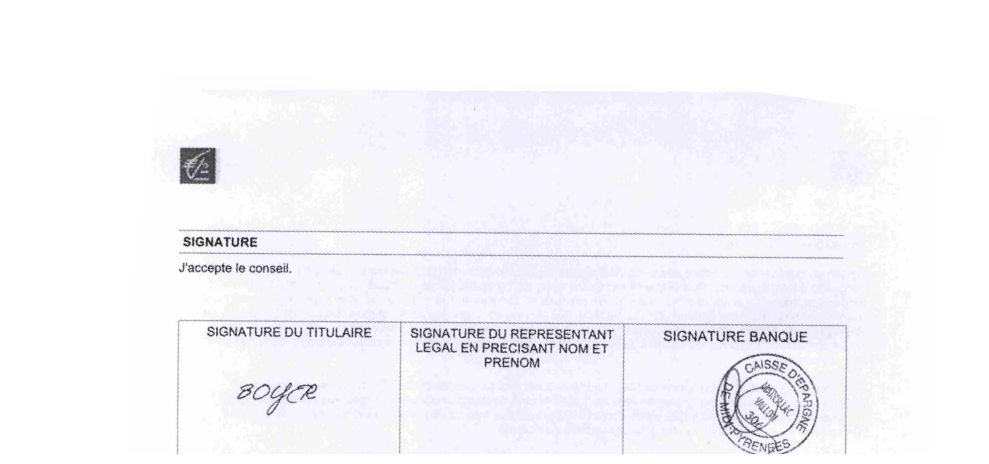

angle Tesseract:  0
Image après rotation tesseract


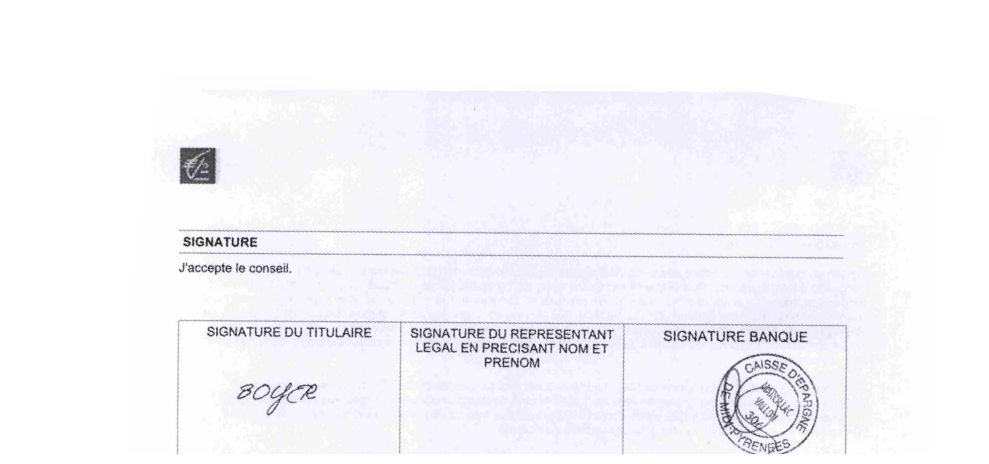

In [63]:
# Test de la rotation d'image
# ----------------------------------------
print("Image avant toute modification")
show_image(im[:900])

### Etape 1 : rotation fine avec get_angle_openCV
mean_angle = get_angle_openCV(im)
print("angle OpenCV: ", mean_angle)
if abs(mean_angle) > 0:
    im = rotate_im(im,mean_angle)
print("Image après rotation OpenCV")
show_image(im[:900])

### Etape 2 : rotation avec get_angle_tesseract pour différencier entre 0° et 180°
try:
    angle = get_angle_tesseract(im)
    print("angle Tesseract: ", angle)
    if abs(angle) > 0:
        im = rotate_im(im,angle)
    print("Image après rotation tesseract")
    show_image(im[:900])
except pytesseract.TesseractError:
    pass

#### Débruitage & Seuillage

In [65]:
# Améliore la qualité de l'image pour la détection de contours.
# -------------------------------------------
def denoise_image(im):
    """
    Cette fonction permet de débruiter une image.

    Input:
    -----
    - im (np.array): image que l'on veut débruiter

    Ouput:
    ------
    - im_thresh (np.array): image débruitée

    =========================== Notes ============================
    On commence par convertir l'image en niveau de gris pour pouvoir appliquer 
    n'importe quel seuillage avec OpenCV. 
    
    On applique ensuite un filtre bilateral pour débruiter l'image tout en conservant les contours.
    Il eciste principalement 3 filtres utilisés pour le débruitage : le filtre gaussien, le filtre 
    median et le filtre bilatéral. 
    Le filtre gaussien et le filtre médian sont tous deux utiles pour débruiter l'image tout en
    conservant les contours. A priori, le filtre médian conserve mieux les contours que le filtre 
    gaussien. Cependant, ce sont des filtres basés sur le domaine de la fonction ne tiennent pas compte
    du fait qu'un pixel est un pixel de bord ou non. 
    Ces filtres se contentent d'attribuer des poids en fonction de la proximité spatiale, 
    ce qui a pour effet d'estomper les contours.
    
    
    Au final, le bilateral filtering (voir explications dans les liens en Reference) 
    est une meilleure méthode pour débruiter tout en préservant les countours. 
    Il existe 2 types de filtres : 
    Les filtres de plage (de valeurs), attribuent des poids en fonction de la différence d'intensité des pixels. 
    Les filtres de domaine attribuent des poids en fonction de la proximité spatiale des pixels (ex: 
    filtre gaussien ou filtre médian).
    Le filtre bilatéral combine filtre de domaine et filtre de plage.
    Le filtre de domaine s'assurera que seuls les pixels proches (disons une fenêtre de 3×3) sont pris en compte 
    pour le flou, puis le filtre de plage s'assurera que les poids dans cette fenêtre de 3×3 sont donnés en 
    fonction de la différence d'intensité par rapport au pixel central. 
    De cette manière, les bords sont préservés. 


    On applique enfin un suillage Adaptatif (Adaptive Thresholding). 
    Le seuillage Adaptatif est plus précis qu'un seuillage binaire et est utile si 
    les conditions d'éclairage d'une image varient d'une zone à l'autre.
    Il détermine le seuil d'un pixel à partir d'une petite région autour de celui-ci
    et permet d'obtenir différents seuils pour différentes régions d'une même image.
    Pour chaque pixel, le seuillage adaptatif examine son voisinage en utilisant une fenêtre de 
    taille (block_size x block_size). La valeur du seuil pour chaque pixel est une somme pondérée 
    par la gaussienne des valeurs de voisinage moins une constante C.
    Si la valeur du pixel est supérieure à la valeur du seuil elle est fixée à la valeur max.
    ==============================================================

    Référence:
    ----------
    - Améliore la qualité d'un pdf : 
      https://medium.com/analytics-vidhya/enhance-a-document-scan-using-python-and-opencv-9934a0c2da3d
      
    - blog parlant de filtre médian et du filtre gaussien mais aussi plein d'autres notions de traitements d'image:
      https://theailearner.com/tag/cv2-medianblur/
      https://theailearner.com/2019/05/06/gaussian-blurring/
      https://theailearner.com/2019/05/07/bilateral-filtering/

      https://ieeexplore.ieee.org/document/9083712

    - pre-processing pour l'OCR :
      https://nanonets.com/blog/ocr-with-tesseract
      
    """
    # Mettre l'image en gris pour appliquer n'importe quel openCV thresholding par la suite 
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    # retire le bruit (cv2.bilateralFilter est meilleur que cv2.medianBlur mais un peu + lent)
    # im_desoised = cv2.medianBlur(im, 3) #image, kernel size
    im_desoised = cv2.bilateralFilter(src=im, #input image
                                      d=5, #filter size. 
                                      sigmaColor = 15, #Filter sigma in the color space (Range Filter)
                                      sigmaSpace = 15) #Filter sigma in the coordinate space (Domain Filter)
    # Rq: Large filters (d > 5) are very slow, so it is recommended to use d=5 for real-time applications.
    # If the sigma values are small (< 10), the filter will not have much effect, whereas if they are large 
    # (> 150), they will have a very strong effect, making the image look “cartoonish”.
    
    # Appliquation du seuillage sur l'image
    im_thresh = cv2.adaptiveThreshold(im_desoised, #image on which to apply the threshold
                                   255,  # maximum value assigned to pixel values exceeding the threshold
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # gaussian weighted sum of neighborhood
                                   cv2.THRESH_BINARY,  # thresholding type
                                   9,  # block size (9x9 window) #essayer aussi 13
                                   10)  # constant (
    
    return im_thresh

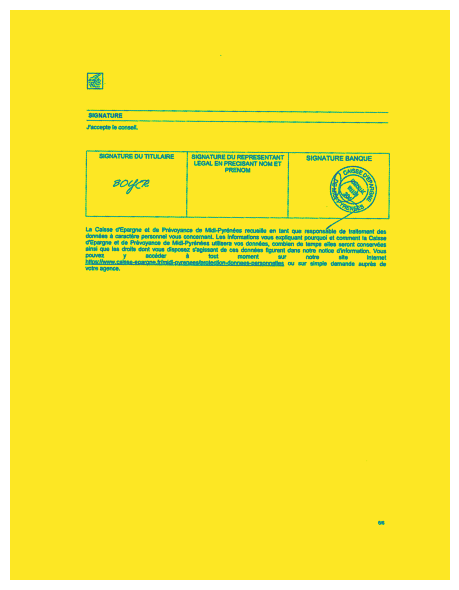

In [66]:
im_thresh = denoise_image(im)
show_image(im_thresh)

In [67]:
# Test de la fonction denoise_image() avec Tesseract
print("-----Tesseract avec pre-processing-----")
results = pytesseract.image_to_data(im_thresh, output_type=pytesseract.Output.DICT)
Text = results["text"] 
Text = ' '.join(Text)
print(Text)

print("\n\n")
print("-----Tesseract sans pre-processing-----")
results = pytesseract.image_to_data(im, output_type=pytesseract.Output.DICT)
Text = results["text"]
Text = ' '.join(Text)
print(Text)

-----Tesseract avec pre-processing-----
    mad  bones  Al    SIGNATURE    Jaccepte fe consail,                   SIGNATURE DU TITULAIRE SIGNATURE BU REPRESENTANT SIGNATURE BANQUE  LEGAL EN PRECISANT NOM ET  PRENOM    BOYER              La Oaisse d'Epargne et de Prévoyance de Midi-Pyrénées recusille en tant que responsable de traiternent des  données  caractére personnel vous concernant. Les informations vous expliquant pourquoi et comment ta Caisse  d'Epargne et de Prévoyance de Midi-Pyrénées utilisera vos données, combien de temps elles seront conservées  ainsi que les droits dont vous disposez s'agissant de ces données figurent dans notre notice d'information. Vous  pouvez ¥ gocéder a tout moment sur notre site internet    hitos:/www.calsse-eparane fr/midi-pyrences/protection-dannees-personnelles ou sur simple demande auprés de    votre agence.    oI



-----Tesseract sans pre-processing-----
              “SIGNATURE         Jaccepte fe conseil.         SIGNATURE DU TITULAIRE SIGNAT

### Template

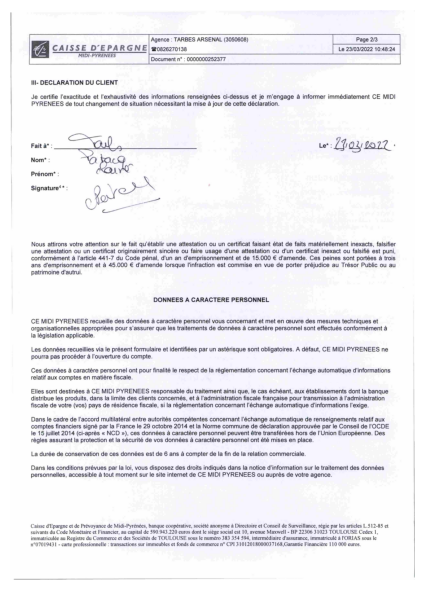

In [83]:
#pdf = load_pdf("006961477.pdf",path_data,poppler_path)

pdf = load_pdf("template_eai_type2.pdf",
               "C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila",
               poppler_path)

im = find_page_with_number(pdf,1)
template_shape = im.shape
show_image(im)

#### read_page()

In [84]:
def read_page(im,output_list=False):
    """
    Cette fonction prend en argument une image le texte
    de l'image à l'aide de l'OCR Tesseract.
    Cette fonction débruite au préalable l'image pour améliorer
    la lecture par tesseract mais la fonction ne rotatione PAS 
    l'image pour la mettre dans le bon sens. 
    
    Intput:
    -------
    - im (np.array) : image à lire
    - output_list (bool) : si True, le texte est renvoyé sous
      forme de liste où chaque élément de la liste est un mot du texte.
      Si False, text est un string.

    Output:
    -----
    - text (liste de string OU string) : texte contenu dans l'image où 
      chaque élément de la liste est un mot du texte si output_list=True
      et texte contenu dans l'image sous forme de string si output_list=False.
    """
    
    # Débruitage de l'image pour améliorer la lecture.    
    im_prep = denoise_image(im)
    text = pytesseract.image_to_data(im_prep,output_type=pytesseract.Output.DICT)["text"]
    
    if not(output_list):
        text = ' '.join(text)
        
    return text

In [85]:
template_text = read_page(im)
print(template_text)

         Agence : TARBES ARSENAL (3050608) Page 2/3              CAISSE D’EPARGNE| ao0826270138 Le 23/03/2022 10:48:24              MIDI-PYRENEES | Document n° : 0000000252377              Ill- DECLARATION DU CLIENT    Je certifie l'exactitude et I'exhaustivité des informations renseignées ci-dessus et je m’engage a informer immédiatement CE MIDI  PYRENEES de tout changement de situation nécessitant la mise a jour de cette déclaration.    Fait a* : Le: / N02 2977 ‘  Nom* : O  Prénom* : e    Signature‘* :    Nous attirons votre attention sur le fait qu’établir une attestation ou un certificat faisant état de faits matériellement inexacts, falsifier  une attestation ou un certificat originairement sincére ou faire usage d'une attestation ou d'un certificat inexact ou falsifié est puni,  conformément a l'article 441-7 du Code pénal, d'un an d'emprisonnement et de 15.000 € d'amende. Ces peines sont portées a trois  ans d'emprisonnement et a 45.000 € d'amende lorsque I'infraction est commis

#### create_template()

In [86]:
def get_screenSize():
    """
    Cette fonction permet d'obtenir la taille de l'écran d'ordinateur.
    
    Output:
    -------
    - screenHeight, screenWidth (int) : hauteur et largeur de l'écran.
    
    Reference:
    ----------
    https://stackoverflow.com/questions/11041607/getting-screen-size-on-opencv
    """
    # create a window in full-screen mode and ask for its width and height
    cv2.namedWindow("dst", cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty("dst",cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_FULLSCREEN)
    (a,b,screenWidth,screenHeight) = cv2.getWindowImageRect('dst')
    cv2.destroyAllWindows()
    return screenHeight, screenWidth #(height, width)
    
    
def ResizeWithAspectRatio(image, width=None, height=None):
    """
    Cette fonction redimensionne l'image d'entrée à une taille spécifique 
    tout en conservant le rapport hauteur/largeur.
    
    Input:
    ------
    - image (np.array): image que l'on souhaiute redimmensionner.
    - width, height (int): largeur et hauteur de l'image.
    
    Output:
    ------
    - resized_image (np.array): image redimensionnée.
    - r (float) : ratio de redimensionnement.
    
    Reference:
    ----------
    - Redimensionne l'image en conservant le bon ratio:
      https://stackoverflow.com/questions/35180764/opencv-python-image-too-big-to-display
    """
    
    dim = None
    (h, w) = image.shape[:2] #(height, width)

    if width is None and height is None:
        return image
    
    if height : 
        r = height / float(h)
        dim = (int(w * r), height) #(width, height)
    else:
        r = width / float(w)
        dim = (width, int(h * r)) #(width, height)

    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized_image, r


def extract_start_rectangle(point_matrix):
    """
    Cette fonction prend en argument les coordonées (x1,y1) et (x2,y2) définissant 
    un rectangle et renvoie le point (xr,yr) en haut à gauche du rectangle ainsi que 
    hr et wr représentant respectivement la hauteur et la largeur du rectangle.
    
    Input:
    -----
    - point_matrix (np.array) : tableau des points définissant le rectangle
      point_matrix = np.array ([[x1,y1],
                                [x2,y2]])
    
    Output:
    ------
    - box_prop (list) : box_prop = [xr,yr,wr,hr] où (xr,yr) est le point en haut à gauche du 
      rectangle et wr,hr sont respectivement la largeur et la hauteur du rectangle.  
    
    =================== Exemple:  =================== 
    (x1,y1) = coordonées de debut du rectangle, (x2,y2) = coordonées de fin du rectangle     
    
    repère : (0,0) *-- x 
                   |
                   y
    
    (x1,y1) *-------
            |      |            alors (xr,yr) = (x1,y1)
            |      |
            -------* (x2,y2) 
    
            -------* (x1,y1)
            |      |            alors (xr,yr) = (x2,y1)
            |      |
    (x2,y2) *-------    
    =================================================
    """
    
    x1,y1 = point_matrix[0]
    x2,y2 = point_matrix[1]

    # Définition largeur et hauteur du rectangle
    wr = abs(x2 - x1) 
    hr = abs(y2 - y1)

    # On s'assure que les coordonées (xr,yr) représentent
    # le point en haut à gauche du rectangle
    if (x1 <= x2) and (y1 <= y2):
        xr,yr = x1,y1
    elif (x1 >= x2) and (y1 <= y2):
        xr,yr = x2,y1
    elif (x1 >= x2) and (y1 >= y2):
        xr,yr = x2,y2
    else: #(x1<= x2) and (y1>=y2)
        xr,yr = x1,y2

    box_prop = [xr,yr,wr,hr] 
    return box_prop


def display_instructions(displayed_text):
    """
    Cette fonction crée une image blanche et affiche le texte 
    contenu dans displayed_text.
    
    Input:
    ------
    - displayed_text (list of string) : liste contenant le texte à afficher.
      A chaque nouvel élément de la liste, une nouvelle ligne de texte est affichée.
    
    Output:
    ------
    - im_text (np.array) : image contenat le texte à afficher.
    """

    # Création d'une image blanche pour y afficher du texte d'aide
    im_text = np.zeros([200,500,3],dtype=np.uint8)
    im_text.fill(255)

    # Affichage du texte d'aide
    x,y = (10,30)
    for text in displayed_text:
        im_text = cv2.putText(im_text, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        y = y + 20
        
    return im_text

def create_template(im,show_instructions=True,windowHeight=None,windowWidth=None):
    """
    Cette fonction permet de définir un template en traçant les rectangles 
    devant contenir les signatures. Ce template n'est à définir qu'une seule fois. 
    >>> Utilise les fonctions get_screenSize(), ResizeWithAspectRatio() 
        et extract_start_rectangle()

    Input:
    ------
    - im (np.array) : image sur laquelle tracer le template.
    - show_instructions (boolean) : si True, une fenêtre contenant 
      les instructions est affichée.
    - windowHeight, windowWidth (int) : taille de l'image à afficher. 
      Si les deux valeurs sont à None, la taille de l'image est calculée 
      pour s'accomoder à la taille de l'écran d'ordinateur. 

    Output:
    ------
    - box_prop_list (liste de np.array) : liste des proportions du rectangle. 
      box_prop_list[0] = [xr,yr,wr,hr] où (xr,yr) est le point en haut à gauche du rectangle
      tracé et wr,hr sont respectivement la largeur et la hauteur du rectangle. 
      Ainsi, si on dessine 2 rectangles sur l'image len(box_prop_list) = 2 et :
      box_prop_list = [[xr1,yr1,wr1,hr1], [xr2,yr2,wr2,hr2]].
      Pour davantage d'infos, voir la doc de la fonction extract_start_rectangle().
    - img (np.array) : image sur laquelle on a tracé les rectangles.

    Reference:
    ----------
    - Dessiner un rectangle sur une image avec OpenCv: 
      https://www.tutorialspoint.com/opencv-python-how-to-draw-a-rectangle-using-mouse-events
      https://mlhive.com/2022/04/draw-on-images-using-mouse-in-opencv-python

    ============================ Notes ============================
    Une fois ce template avec les rectangles définis, on calculera les coordonées des rectangles 
    en fonction des coordonées de mots clés sur la page (ex: mot clé SIGNATURE). 
    Ainsi, lorsqu'un nouveau pdf se présentera, les coordonées des rectangles s'adapteront directement 
    aux coordonnées des mots clés et les rectangels seront donc toujours bien situés.
    ==============================================================
    """
    global rectangle_list, point_matrix, counter, drawing, ix, iy, img
    
    #windowHeight,windowWidth = None,None
    img = im.copy()

    # ======================================
    # Définition des variables 
    # ======================================
    # Récupère la taille de l'écran de l'ordinateur
    if windowHeight is None and windowWidth is None:
        windowHeight,windowWidth = get_screenSize()    

    # Variables pour dessiner sur l'image
    drawing = False
    ix,iy = -1,-1
    # Compteur pour savoir le n° du rectangle que l'on dessine
    # (on peut dessiner plusieurs rectangles sur une même image)
    counter = 0

    # Crée une matrice de points pour stocker les coordonnées du clic de la souris 
    # sur l'image ie stocker les coordonées des rectangles dessinés.
    point_matrix = np.zeros((2,2),int) # point_matrix = array([[x1,y1],
                                       #                      [x2,y2]])

    # Liste des coordonées des rectangles dessinés. 
    # Contient les point_matrix de chaque rectangle  
    # i.e. c'est une liste de tableaux array([[x1,y1], 
    #                                         [x2,y2]])
    # où [x1,y1] sont les coordonées de début du rectangle 
    # et [x2,y2] sont les coordonnées de fin de rectangle. 
    rectangle_list = [] 
    
    # ======================================
    # define mouse callback function to draw a rectangle
    # ======================================
    def draw_rectangle(event, x, y, flags, param):
        global ix, iy, drawing, img, counter, point_matrix 

        if event == cv2.EVENT_LBUTTONDOWN: #check if mouse event is left button down
            # checking if any left click (cv2.EVENT_LBUTTONDOWN) is happening or not
            drawing = True #on commence à enregistrer la souris
            ix = x
            iy = y
            # storing pixel coordinates of each point where we have done mouse click on image
            point_matrix[counter] = x,y #accès à la 1ère ligne de point_matrix: coordonées (x1,y1) du rectangle 
            counter += 1 # on a dessiné le 1er point (x1,y1), incrémentation du compteur.

        elif event == cv2.EVENT_LBUTTONUP: #check if mouse event is Left button up
            drawing = False #on arrête d'enregistrer la souris
            cv2.rectangle(img, (ix, iy),(x, y),(0, 0, 255),1) # on dessine le rectangle
            point_matrix[counter] = x,y #accès à la 2e ligne de point_matrix: coordonées (x2,y2) du rectangle 
            # ajout des coordonées (x1,y1),(x2,y2) (= le 1er rectangle) à la liste de tous les rectangles dessinés
            rectangle_list.append(point_matrix) 
            counter = 0  # remise à zéro du compteur pour le prochain rectangle
            point_matrix = np.zeros((2,2),int) # remise à zéro de la matrice de points pour le prochain rectangle

    # ======================================
    # Create window to draw and connect the mouse
    # ======================================   
    # Create a window to draw the rectangles
    cv2.namedWindow("Template")

    # And bind the function to window :
    # connect the mouse button to our callback function
    # callback function is a function passed into another function as an argument
    cv2.setMouseCallback("Template", draw_rectangle)
    
    # ======================================
    # Create window to display instuctions
    # ======================================  
    if show_instructions:
        displayed_text = ['Dessiner les rectangles contenant la signature.',
                    '   "Exit" pour annuler.', '   "Enter" pour sauvegarder.',
                    '   "Ctrl+z" pour retour en arriere.']
        im_text = display_instructions(displayed_text)

    # ======================================
    # Display the window
    # ======================================
    #on recupère la valeur du ratio que la première fois qu'on passe dans la boucle while
    #sinon, les autres fois, ratio vaut toujours 1 
    first_ratio = True 
    while True:
        
        # Redimensionne l'image en conservant le ratio pour que la hauteur 
        # de l'image soit la même que la hauteur de l'écran.
        # Sinon, OpenCV n'adapte pas la taille de la fenêtre à l'écran
        if first_ratio : # stocke valeur du ratio uniquement la 1er fois qu'on passe dans la boucle
            img,ratio = ResizeWithAspectRatio(img, height=windowHeight, width=windowWidth)
            first_ratio = False
        else : # pour les autres fois, ratio vaut toujours 1
            img,_ = ResizeWithAspectRatio(img, height=windowHeight, width=windowWidth)
            
        
        # Affiche l'image
        cv2.imshow("Template", img)
        
        if show_instructions:
            cv2.imshow("Instructions", im_text)

        k = cv2.waitKey(10)

        if k == 27: #key "escape" to stop and delete changes
            print("Exit - template not saved.")
            img = im.copy() #reset image
            rectangle_list = [] #reset list of coordinates 
            break # escape window

        elif k == 13: #key "enter" to stop and save changes
            print("Template successfully saved.")
            break # escape window and all parameters are saved

        elif k == 26: #key "ctrl + z" to come back 
            img = im.copy() #reset image
            counter = 0 #reset counter
            rectangle_list = [] #reset list of coordinates 

    cv2.destroyAllWindows()
    
    # Comme on a appliqué un redimensionnement, il faut remettre 
    # les coordonées à l'échelle d'origine.
    # On calcule de plus avec la fonction extract_start_rectangle les 
    # proportions du rectangle (voir la doc de extract_start_rectangle)
    # pour d'avantage d'infos
    box_prop_list = []
    for i in range(len(rectangle_list)):
        temp = np.multiply(rectangle_list[i],1/ratio).astype(int)
        box_prop_list.append(extract_start_rectangle(temp))
                 
    return box_prop_list,img

Template successfully saved.


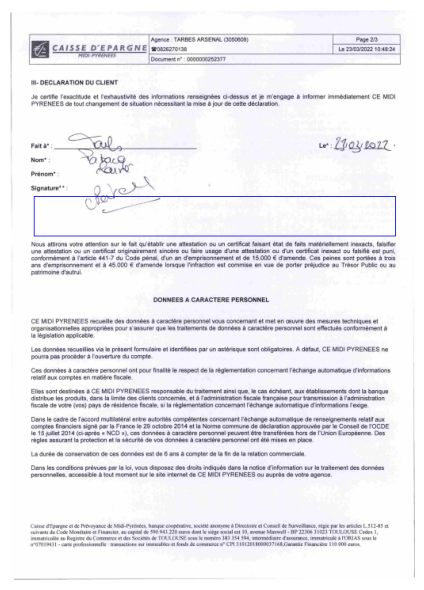

[[97, 767, 1489, 163]]


In [87]:
box_prop_list,img = create_template(im)
show_image(img)
print(box_prop_list)

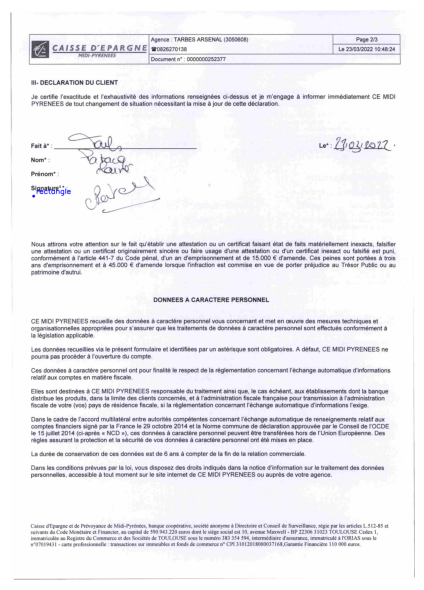

In [88]:
# Vérification que box_prop_list est correct
# ----------------------------------------
image = im.copy()

for i in range(len(box_prop_list)):
    xr_,yr_ = box_prop_list[i][:2]
    cv2.circle(image, (xr_, yr_), radius=3, color=(0, 0, 255), thickness=4)
    cv2.putText(image, "rectangle", (xr_+ 10 , yr_ - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
show_image(image)

#### find_all_keyWord_coord()

In [89]:
def strip_accents(s):
    """
    Cette fonction retire les accents du mot string s
    Reference : 
    https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def find_expression_in_list(list_of_strings,expression,special_char='#!#'):
    """
    Cette fonction permet de trouver la position d'une expression dans 
    une liste de strings où chaque élément de cette liste est un mot.
    
    Input:
    ------
    - list_of_strings (list de string) : liste de strings où chaque élément 
      de la liste correspond à un mot.
    - expression (string) : expression à trouver dans list_of_strings.
      Peut contenir plusieurs mots séparés par des espaces.
    - special_char (string) : caractère spécial dont on se sert pour 
      trouver l'indice. Attention, special_char ne doit PAS être un 
      caractère regex comme |, ?, ., ^, $
    
    Output:
    ------
    - idx (integer) : indice du début de la position de l'expression 
      dans la liste list_of_strings. Si aucune correspondance n'est
      trouvée, idx=None. 
    
    ========================== Notes ==========================
    Par exemple: Si list_of_strings = ["Voici", "une", "liste", "où",  
    "chaque", "élément", "est", "un", "mot"] et expression = ["chaque élément"]
    alors la fonction renvoie la valeur 5 qui correspond à la position
    du début de l'expression dans la liste list_of_strings.
    
    On retire d'abord tous les accents de list_of_strings et expression
    pour rendre la recherche + robuste.
    
    Pour ce faire, on fusionne list_of_strings et expression en un seul string 
    en séparant les espaces par special_char='#': 
    list_of_strings = "Voici#une#liste#où#chaque#élément#est#un#mot"
    expression = "chaque#élément"
    
    On recherche la première occurence de "chaque#élément" dans 
    list_of_strings avec regex. On obtient ainsi l'indice du premier
    élément ici 19 car le 'c' de "chaque#élément" est le caractère
    n°19 dans list_of_strings (les indices commencent à 0).
    
    Enfin, on regarde list_of_strings[0:19] et on compte le nombre
    de special_char ce qui nous donne l'indice du premier mot de expression
    dans la liste list_of_strings donc idx = 5.
    ===========================================================
    """

    # On fusionne la liste list_of_strings en un seul string en
    # séparant chaque élément de la liste par le caractère spécial    
    list_of_strings = special_char.join(list_of_strings)
    # On retire tous les accents pour rendre la recherche + robuste
    list_of_strings = ''.join(c for c in unicodedata.normalize('NFD', list_of_strings) if unicodedata.category(c) != 'Mn')
    
    # On remplace dans expression les espaces par le caractère spécial    
    expression = expression.replace(' ', special_char)  
    # On retire tous les accents pour rendre la recherche + robuste
    expression = ''.join(c for c in unicodedata.normalize('NFD', expression) if unicodedata.category(c) != 'Mn')

    # On recherche la première occurence de l'expression dans 
    # la liste de strings
    res = re.search(expression,list_of_strings)
    
    # si on a trouvé une correspondance:
    if res:
        # On compte le nombre de special_char du début de list_of_strings 
        # jusqu'à au premier élément de expression et on trouve donc 
        # l'indice du début de expression dans list_of_strings
        idx = list_of_strings[:res.start()].count(special_char)
    else:
        idx = None

    return idx

def find_all_keyWord_coord_v0(im, keyWords_template, debug=False, min_conf=80):
    """
    Cette fonction recherche la position de tous les 
    mots clés de la liste keyWords_template. ATTENTION, dans ce cas, l'image doit être "parfaite" 
    c'est à dire que tous les mots clés doivent être lisibles par Tesseract. 
    Sinon, une erreur peut se produire. Dans ce cas, une solution est de changer 
    l'image d'entrée ou de modifier la liste des mots clés. 
    >>> utilise la fonction find_expression_in_list() 


    Input:
    ------
    - im (np.array): image sur laquelle recherche les coordonées des mots clés.
    - keyWords_template (list of string): liste des mots clés à rechercher. La recherche se fait
      dans l'ordre des mots de keyWords_template. Dès qu'un mot est trouvé, on ne recherche pas les 
      mots suivants. Attention à ne pas mettre d'espace à la fin et au début des mots ou des expressions. 
      Ex : ['TITULAIRE','REPRESENTANT LEGAL','BANQUE'] 
    - debug (bool): si True, l'ensemble du texte détecté est affiché avec son niveau de confiance.
      Si un mot clé a été trouvé, l'image avec le mot clé encadré est également affichée.
    - min_conf (int): niveau de confiance minimale pour l'affichage du texte trouvé dans le cas 
      où debug=True.

    Output:
    -------
    - key_points_dict (dict): dictionnaire de coordonnées 
      ['TITULAIRE':(xa,ya),'REPRESENTANT':(xb,yb),'BANQUE':(xc,yc)] des
      mots trouvés. En key : le mot et en value ses coordonées.
      
      =============================== Notes ==================================
      Règles d'or pour le choix de keyWords_template : 
      - Chaque élément de la liste keyWords_template peut être un seul mot ou une expression
      - Tous les mots de la liste dovent être présent dans la page
      - Chaque mot de la liste ne doit être présent qu'une seule fois dans la page
      - Ne pas mettre d'espace après les mots de la liste keyWords_template.
      ========================================================================
      
    """

    image = im.copy() 

    # ==============================================
    # Extraction des informations de l'image
    # ==============================================
    #debruitage de l'image pour meilleure lecture
    im_prep = denoise_image(image)
    #extrcation de toutes les informations de l'image à l'aide de Tesseract
    results = pytesseract.image_to_data(im_prep, output_type=pytesseract.Output.DICT)
    #liste de tous les mots trouvés par Tesseract
    Text = results["text"] 

    # Dictionnaire de coordonnées des mots. En key : le mot et en value 
    # ses coordonées
    key_points_dict = dict()

    # ==============================================
    # Recherche de la position de tous les mots clés
    # ==============================================
    # parcourt de tous les mots de la liste
    for i in range(len(keyWords_template)):
        #mot clé 
        keyWord = keyWords_template[i] 
        #indice du mot keyWords_template[i] dans la liste Text
        #-- Méthode 1 avec np.where. Ne trouve que le mot exactement identique à 'TITULAIRE' par ex.
        #idx = np.where(np.array(Text) == keyWord)[0][0]
        #-- Méthode 2 avec Regex. Peut trouver 'TITULAIRE' dans 'DUTITULAIREE'
        #idx = [j for j, item in enumerate(Text) if re.search(keyWord, item)][0]
        #-- Méthode 3 avec find_expression_in_list
        idx = find_expression_in_list(Text,keyWord)
        try :
            # (x,y) = positions du mot keyWords_template[i]
            # le point d'origine (0,0) se trouve en haut à gauche du document 
            x = results["left"][idx] #abscisse du mot (point en haut à gauche)
            y = results["top"][idx] #ordonnée du mot (point en haut à gauche)

            #ajout des coordonées du mot keyWords_template[i] à la liste des coordonées
            key_points_dict[keyWord] = (x,y) 
 
            if debug:
                w = results["width"][idx] #hauteur du rectangle contenant le mot
                h = results["height"][idx] #largueur du rectangle contenant le mot
                # draw a bounding box around the text
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # draw the text 
                stripped_keyWord = ''.join(c for c in unicodedata.normalize('NFD', keyWord) if unicodedata.category(c) != 'Mn')
                cv2.putText(image, stripped_keyWord, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
                # display image

        except TypeError as e:
            raise TypeError("\n\nLe mot '{}' n'a pas pu être trouvé sur la page du pdf. " 
            "Tous les mots clés doivent être trouvés sur la page. "
            "Modifier la liste des mots clés à trouver ou sélectionner une autre page plus lisible.".format(keyWord)) from e
    
    # ==============================================
    # Dans le cas où on a trouvé les mots,
    # on peut afficher les mots trouvés sur l'image pour debugging
    # ==============================================
    if debug : 
        print(">>> Fonction find_all_keyWord_coord() <<<")
        debug_text = [] #liste contenant tous les mots trouvés sur la page

        # loop over each of the individual text localisations
        for j in range(0, len(results["text"])):
            # extract the OCR text itself along with the confidence of the
            # text localization
            text = results["text"][j] #recognized text string
            conf = int(results["conf"][j]) #confidence of the detected text localization.
        
            # filter out weak confidence text localizations
            if conf > min_conf :
                # display the confidence and text to our terminal
                debug_text.append(text + " (conf:" + str(conf) + ")")         

        print("\n----- Texte trouvé avec un niveau de confiance >= " + str(min_conf) + " : -----")
        print(debug_text)
        print("\n----- Mots détectés sur l'image : -----")
        show_image(image)
    # ==============================================
    
    return key_points_dict


def find_all_keyWord_coord(im, keyWords_template, debug=False):
    """
    Cette fonction recherche la position de tous les 
    mots clés de la liste keyWords_template. ATTENTION, dans ce cas, l'image doit être "parfaite" 
    c'est à dire que tous les mots clés doivent être lisibles par Tesseract. 
    Sinon, une erreur peut se produire. Dans ce cas, une solution est de changer 
    l'image d'entrée ou de modifier la liste des mots clés. 
    >>> utilise la fonction find_expression_in_list() 


    Input:
    ------
    - im (np.array): image sur laquelle recherche les coordonées des mots clés.
    - keyWords_template (list of string): liste des mots clés à rechercher. La recherche se fait
      dans l'ordre des mots de keyWords_template. Dès qu'un mot est trouvé, on ne recherche pas les 
      mots suivants. Attention à ne pas mettre d'espace à la fin et au début des mots ou des expressions. 
      Ex : ['TITULAIRE','REPRESENTANT LEGAL','BANQUE'] 
    - debug (bool): si True, l'ensemble du texte détecté est affiché.
      Si un mot clé a été trouvé, l'image avec le mot clé encadré est également affichée.
   
    Output:
    -------
    - key_points_dict (dict): dictionnaire de coordonnées 
      ['TITULAIRE':(xa,ya),'REPRESENTANT':(xb,yb),'BANQUE':(xc,yc)] des
      mots trouvés. En key : le mot et en value ses coordonées.
      
      =============================== Notes ==================================
      Règles d'or pour le choix de keyWords_template : 
      - Chaque élément de la liste keyWords_template peut être un seul mot ou une expression
      - Tous les mots de la liste dovent être présent dans la page
      - Chaque mot de la liste ne doit être présent qu'une seule fois dans la page
      - Ne pas mettre d'espace après les mots de la liste keyWords_template.
      ========================================================================
      
    """

    image = im.copy() 

    # ==============================================
    # Extraction des informations de l'image
    # ==============================================
    #debruitage de l'image pour meilleure lecture
    im_prep = denoise_image(image)
    #extrcation de toutes les informations de l'image à l'aide de Tesseract
    results = pytesseract.image_to_data(im_prep, output_type=pytesseract.Output.DICT)
    #liste de tous les mots trouvés par Tesseract
    Text = results["text"] 
    
    # Dictionnaire de coordonnées des mots. En key : le mot et en value 
    # ses coordonées
    key_points_dict = dict()

    # ==============================================
    # Recherche de la position de tous les mots clés
    # ==============================================
    # parcourt de tous les mots de la liste
    for i in range(len(keyWords_template)):
        #mot clé 
        keyWord = keyWords_template[i] 
        #indice du mot keyWords_template[i] dans la liste Text
        #-- Méthode 1 avec np.where. Ne trouve que le mot exactement identique à 'TITULAIRE' par ex.
        #idx = np.where(np.array(Text) == keyWord)[0][0]
        #-- Méthode 2 avec Regex. Peut trouver 'TITULAIRE' dans 'DUTITULAIREE'
        #idx = [j for j, item in enumerate(Text) if re.search(keyWord, item)][0]
        #-- Méthode 3 avec find_expression_in_list
        idx = find_expression_in_list(Text,keyWord)
        try :
            # (x,y) = positions du mot keyWords_template[i]
            # le point d'origine (0,0) se trouve en haut à gauche du document 
            x = results["left"][idx] #abscisse du mot (point en haut à gauche)
            y = results["top"][idx] #ordonnée du mot (point en haut à gauche)

            #ajout des coordonées du mot keyWords_template[i] à la liste des coordonées
            key_points_dict[keyWord] = (x,y) 
 
            if debug:
                w = results["width"][idx] #hauteur du rectangle contenant le mot
                h = results["height"][idx] #largueur du rectangle contenant le mot
                # draw a bounding box around the text
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # draw the text 
                stripped_keyWord = ''.join(c for c in unicodedata.normalize('NFD', keyWord) if unicodedata.category(c) != 'Mn')
                cv2.putText(image, stripped_keyWord, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
                # display image

        except TypeError as e:
            raise TypeError("\n\nLe mot '{}' n'a pas pu être trouvé sur la page du pdf. " 
            "Tous les mots clés doivent être trouvés sur la page. "
            "Modifier la liste des mots clés à trouver ou sélectionner une autre page plus lisible.".format(keyWord)) from e
    
    # ==============================================
    # Dans le cas où on a trouvé les mots,
    # on peut afficher les mots trouvés sur l'image pour debugging
    # ==============================================
    if debug : 
        print(">>> Fonction find_all_keyWord_coord() <<<")
        print("\n----- Texte trouvé : -----")
        print(Text)
        print("\n----- Mots détectés sur l'image : -----")
        show_image(image)
    # ==============================================
    
    return key_points_dict

>>> Fonction find_all_keyWord_coord() <<<

----- Texte trouvé : -----
['', '', '', '', ' ', '', '', '', 'Agence', ':', 'TARBES', 'ARSENAL', '(3050608)', 'Page', '2/3', '', '', '', ' ', '', '', '', ' ', '', '', '', 'CAISSE', 'D’EPARGNE|', 'ao0826270138', 'Le', '23/03/2022', '10:48:24', '', '', '', ' ', '', '', '', ' ', '', '', '', 'MIDI-PYRENEES', '|', 'Document', 'n°', ':', '0000000252377', '', '', '', ' ', '', '', '', ' ', '', '', '', 'Ill-', 'DECLARATION', 'DU', 'CLIENT', '', '', '', 'Je', 'certifie', "l'exactitude", 'et', "I'exhaustivité", 'des', 'informations', 'renseignées', 'ci-dessus', 'et', 'je', 'm’engage', 'a', 'informer', 'immédiatement', 'CE', 'MIDI', '', 'PYRENEES', 'de', 'tout', 'changement', 'de', 'situation', 'nécessitant', 'la', 'mise', 'a', 'jour', 'de', 'cette', 'déclaration.', '', '', '', 'Fait', 'a*', ':', 'Le:', '/', 'N02', '2977', '‘', '', 'Nom*', ':', 'O', '', 'Prénom*', ':', 'e', '', '', '', 'Signature‘*', ':', '', '', '', 'Nous', 'attirons', 'votre', 'attentio

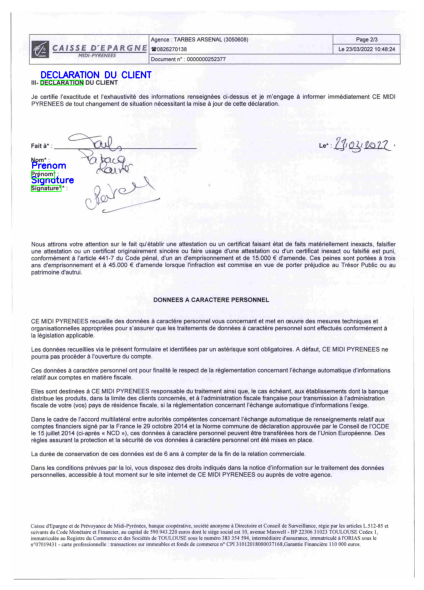

key_points_dict : {'Signature': (87, 722), 'Prenom': (88, 662), 'DECLARATION DU CLIENT': (125, 289)}


In [90]:
keyWords_template = ['SIGNATURE DU TITULAIRE','REPRESENTANT','BANQUE','CAISSE', 'Prévoyance']
#keyWords_template = ["Signature","Nom","Prenom","Fait à","DONNEES A CARACTERE PERSONNEL","DECLARATION DU CLIENT"]

key_points_dict = find_all_keyWord_coord(im, keyWords_template, debug=True)
print("key_points_dict :", key_points_dict)

#### compute_relative_coord()

In [31]:
def compute_relative_coord(box_prop_list,key_points_dict):
    """
    Cette fonction calcule les coordonées relatives d'un point (xr,yr) 
    par rapport à un nouveau point d'origine (x0,y0). Le point 
    (x0,y0) devient alors la "nouvelle origine". 
    
    Input:
    ------
    - box_prop_list (liste de np.array) : liste de proportions des rectangles. 
      box_prop_list[0] = [xr,yr,wr,hr] où (xr,yr) est le point en haut à gauche du rectangle
      et wr,hr sont respectivement la largeur et la hauteur du rectangle. 
      Le point (xr,yr) est le point pour lequel on veut calculer la position relative par rapport
      à une nouvelle origine (x0,y0).
      Rq : si on a 2 rectangles alors box_prop_list = [[xr,yr,wr,hr], [xr2,yr2,wr2,hr2]].
    
    - key_points_dict (dict): dictionnaire des points d'origine (x0,y0),(x1,y1)... par rapport 
      auxquels on calcule la position relative de (xr,yr)
      En key : le mot auquel correspond la coordonée (x0,y0), en value la coordonée (x0,y0).
      Par exemple : key_points_dict = ['TITULAIRE':(x0,y0),'REPRESENTANT':(x1,y1),'BANQUE':(x2,y2)]
    
    Output:
    ------
    - list_relative_points (list de dict) : liste de dictionnaires où chaque élément de la liste
      représente les coordonnées relatives d'un rectangle.
      Par exemple : list_relative_points[0] = {'TITULAIRE': [xr-x0 , yr-y0, wr, hr],
      'REPRESENTANT': [xr-x1 , yr-y1, wr, hr],'BANQUE': [xr-x2 , yr-y2, wr, hr]},
      est un dictionnaire représentant les coordonnées relatives du premier rectangle
      box_prop_list[0] = [xr,yr,wr,hr] par rapport aux différents mots clés servant de 
      coordonnées d'origine key_points_dict = ['TITULAIRE':(x0,y0),
      'REPRESENTANT':(x1,y1),'BANQUE':(x2,y2)].
      list_relative_points[1] représente les coordonées relatives du 2e rectangle par 
      rapport aux différentes origines.
      On remarque que la largeur et la hauteur wr1 et hr1 restent inchangées pour 
      le rectangle 1.
      
      ===================== Notes =======================  
       Si nous avons redimensioné d'un rapport Rx = nouveauX/ancienX sur l'axe des x
       et d'un rapport Ry = nouveauY/ancienY sur l'axe des y.
       Alors nos nouvelles coordonnées pour le point (x,y) sont (Rx * x, Ry * y).
      ===================================================    
    """
    
    list_relative_points = []

    for i in range(len(box_prop_list)):    
        # dictionnaire 
        temp_dict = dict()

        for keyWord in key_points_dict.keys():
            # nouvelle origine (x,y)
            x,y = key_points_dict[keyWord] 
            # coordonées du point (xr,yr)
            xr,yr,wr,hr = box_prop_list[i]
            # nouvelles coordonées du point (xr,yr)
            # par rapport au point (x,y)
            xr_relatif = xr - x
            yr_relatif = yr - y
            # mise à jour 
            temp_dict[keyWord] = [xr_relatif,yr_relatif,wr,hr]

        list_relative_points.append(temp_dict)
    
    return list_relative_points

box_prop_list : [[94, 519, 432, 237], [587, 578, 413, 175]] 

key_points_dict : {'SIGNATURE DU TITULAIRE': (136, 479), 'REPRESENTANT': (800, 478), 'BANQUE': (1364, 477), 'CAISSE': (159, 70), 'Prévoyance': (399, 834)} 

list_relative_points : [{'SIGNATURE DU TITULAIRE': [-42, 40, 432, 237], 'REPRESENTANT': [-706, 41, 432, 237], 'BANQUE': [-1270, 42, 432, 237], 'CAISSE': [-65, 449, 432, 237], 'Prévoyance': [-305, -315, 432, 237]}, {'SIGNATURE DU TITULAIRE': [451, 99, 413, 175], 'REPRESENTANT': [-213, 100, 413, 175], 'BANQUE': [-777, 101, 413, 175], 'CAISSE': [428, 508, 413, 175], 'Prévoyance': [188, -256, 413, 175]}]


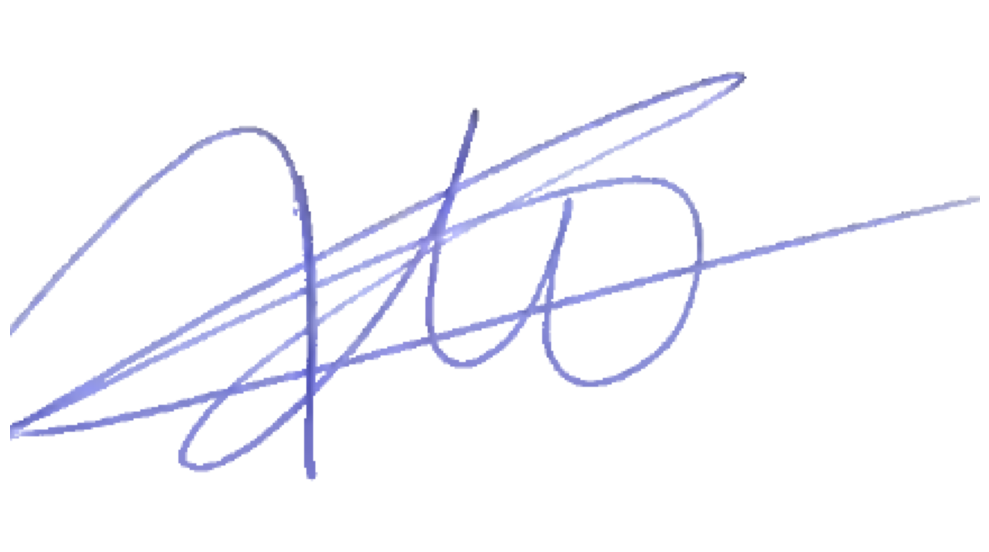

In [32]:
# Test de la fonction compute_relative_coord
# ---------------------------------------------
list_relative_points = compute_relative_coord(box_prop_list,key_points_dict)

print("box_prop_list :", box_prop_list,"\n") 
print("key_points_dict :", key_points_dict,"\n")
print("list_relative_points :", list_relative_points)

#quelquesoit de i, on devrait visualiser la même image
i = 0
keyWords = list(key_points_dict.keys())
rec_num = 0 #numéro du rectangle qu'on veut observer

xr_relatif,yr_relatif,wr,hr =  list_relative_points[rec_num][keyWords[i]]
x,y = key_points_dict[keyWords[i]]

im_box = im[y+yr_relatif:y+yr_relatif+hr, x+xr_relatif:x+xr_relatif+wr]
show_image(im_box)

### Signature Extraction

La section ci-dessous est à améliorer : que faire quand la page est tournée ? 

In [25]:
!ls

006061477_black_contour.PNG
006061477_black_contour_small.PNG
006956080.pdf
006956080_removed.pdf
006961477.pdf
006969920.pdf
007308023.pdf
007325270.pdf
007333320.pdf
007417781.pdf
007418530.pdf
007538249.PNG
007538249.pdf
007538249_truncated_1.pdf
007538249_truncated_2.pdf
008120289.PNG
008120289.pdf
008120289_perspective_1.pdf
008120289_perspective_2.pdf
008120289_rotated_180.pdf
008120289_rotated_30.pdf
008120289_rotated_70.pdf
008120289_rotated_90.pdf
Nouveau Document Microsoft Word.docx
test.xlsx


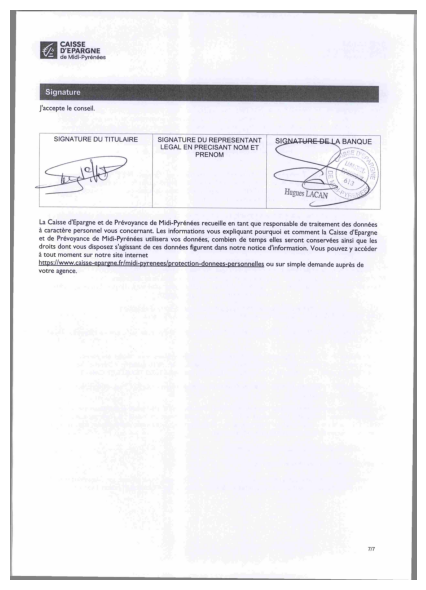

In [33]:
#pdf = load_pdf(pdf_name="13135_007332173_CTEA_2022-03-10_ACQ13135-3177064-1646922710644-14228.pdf",
#               pdf_path="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/Scans 2022-2023/All",
#               poppler_path=poppler_path)

pdf = load_pdf("007538249.pdf",path_data,poppler_path)
show_image(pdf[-1])

#### find_page_with_Tesseract() : avec mots clés

Lecture des pages : on rotationne la page puis on essaie de trouver le mot clé. 
Ne demande pas trop de ressource car en général la bonne page est la dernière donc l'algo de recherche s'arrête assez vite.

In [34]:
# Sélection de la page contenant la signature 
# ------------------------------------
def find_page_with_Tesseract_v0(pdf,keyWords,template_shape=(2338,1654),verbose:bool=False):
    """
    Cette fonction permet de renvoyer la page du pdf contenant au moins un
    des mots clés de la liste keyWords.
    La recherche se fait en partant de la dernière page du pdf et en remontant
    j'usqu'à la première page car la signature se trouve généralement à la fin du
    pdf. Dès que la page est trouvée, la recherche s'arrête. 
    Avant de lire la page avec tesseract, une rotation de la page et un
    débruitage + seuillage de l'image sont appliqués dans le but d'améliorer
    la lecture.     
    
    Rq: Avant de calculer la position des mots, l'image à analyser est mise à la même
    échelle que l'image template. Ceci s'avère utile par la suite pour le calcul des 
    coordonées dans le cas où l'image à analyser n'aurait pas la même taille que l'image 
    template.
    
    >>> Utilise les fonctions get_angle_openCV(), get_angle_tesseract(), 
        rotate_im() et denoise_image(). Pour davantage d'information,
        consulter la description de ces fonctions. 
        Utilise la fonction show_image() si verbose=True.
    
     Input:
    ------
    - pdf (liste de PIL.PpmImagePlugin.PpmImageFile): ensemble des pages du pdf
    - keyWords (list de string): liste contenant les mots ou expressions à rechercher
      sur chaque page. Attention à ne pas mettre d'espaces au début et à la fin des 
      expressions. Ex: keyWords = ["SIGNATURE", "SIGNATURE DU TITULAIRE"]
    - template_shape (tuple) : (height,width) ou (height,width,depth) taille de l'image
      ayant servi de template. Avant de calculer la position des mots, l'image à analyser
      est mise à la même échelle que l'image template. 
    - verbose (bool): si True, affiche l'image aux différentes étapes de l'algorithme.
    
    Output:
    ------
    - final_im (np.array): image contenant au moins un des mots   
      clés de keyWords.    
    - image_info (dict): dictionnaire renvoyé par pytesseract.image_to_data()
      contenant toute l'information de la page. Ceci permet de réutiliser 
      image_info dans d'autres fonctions, sans avoir besoin de relire la page
      tesseract.
    - warning (bool): si True, aucun mot clé n'a été trouvé dans le pdf. 
      La dernière page du pdf sera alors retournée par défaut.
      
    Référence:
    ---------
    - transformation d'une image du format PIL.Image au format np.array :
      https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format
    """
    # ==========================================
    # Transformation de la liste keyWords pour qu'elle soit compréhensible par regex
    # ==========================================
    # le caractère '|' signifie "ou"
    keyWords_ = [] # keyWords_ = string compréhensible par regex
    for w in keyWords:
        keyWords_.append(w + "|") #ajout du symbole "ou" à la fin de chaque mot
    keyWords_ = ''.join(keyWords_) #concaténation de la liste de string en 1 seul string
    keyWords_ = '(' + keyWords_[:-2] + ')' #suppression espace à la fin de kewWords_ & ajout de parenthèses

    # ==========================================
    # Recherche de la page du pdf contenant au moins un des mots clés
    # ==========================================
    #si aucun mot clé n'est trouvé dans le texte, warning passera à True
    warning = False
    #boolean indiquant si on a trouvé ou non la page contenant la signature 
    found = False 
    #compteur pour les pages du pdf. Pour être + rapide, on lit les pages en partant de la fin
    #car la signature est généralement présente à la fin du pdf.
    i = len(pdf)-1

    # I) Recherche des mots clés sur chaque page du pdf
    # -------------------------------------
    while not(found):
        #page i du pdf
        im = pdf[i] 
        #Transformation de l'image du format PIL.Image au format np.array
        im = np.array(im)
        #Redimensionnement de l'image à la même taille que le template
        im = cv2.resize(im, (template_shape[1],template_shape[0]), interpolation = cv2.INTER_AREA)
        
        if verbose: #affichage de l'image si verbose=True
            print(">>> Fonction find_page_with_Tesseract() <<<")
            print("\nImage d'origine :")
            show_image(im)
        
        # 1) Rotation de l'image pour une meilleure lecture 
        # -------------------------------------
        # Etape 1 : rotation fine avec get_angle_openCV()
        angle1 = get_angle_openCV(im)
        if angle1 != 0:
            im = rotate_im(im,angle1)
            if verbose: #affichage de l'image si verbose=True
                print("Image après rotation openCV :")
                print("angle openCV :", angle1)
                show_image(im)
                
        # Etape 2 : rotation avec get_angle_tesseract() pour différencier entre 0° et 180°
        angle2 = get_angle_tesseract(im)
        if angle2 != 0:
            im = rotate_im(im,angle2)
            if verbose: #affichage de l'image si verbose=True
                print("Image après rotation Tesseract :")
                print("angle Tesseract :", angle2)
                show_image(im)
            
        # 2) Pre-processing de l'image pour améliorer la lecture
        # -------------------------------------
        im = denoise_image(im)
        if verbose: #affichage de l'image si verbose=True
            print("Image après pre-processing :")
            show_image(im)
        
        # 3) Extraction du texte de la page i avec tesseract
        # -------------------------------------
        results = pytesseract.image_to_data(im, output_type=pytesseract.Output.DICT)
        txt = ' '.join(results['text'])
        
        #recherche dans txt, de la première occurence d'un des mots de keyWords_
        res = re.search(keyWords_,txt)
        
        #si un mot a été trouvé
        if res:
            found = True #on met found à true
            final_im = im #on récupère la page contenant la signature 
            image_info = results #on récupère les informations de la page
        #sinon, on passe à la page suivante
        else:
            i-=1

    #II) Si après recherche de toutes les pages, aucun mot clé n'a été trouvé,
    #    le document est considéré comme une anomalie
    # -------------------------------------
    if found == False: 
        warning = True #anomalie
        final_im = pdf[-1] #la dernière page du pdf est retournée par défault.
        
    return final_im, image_info, warning 

>>> Fonction find_page_with_Tesseract() <<<

Image d'origine :


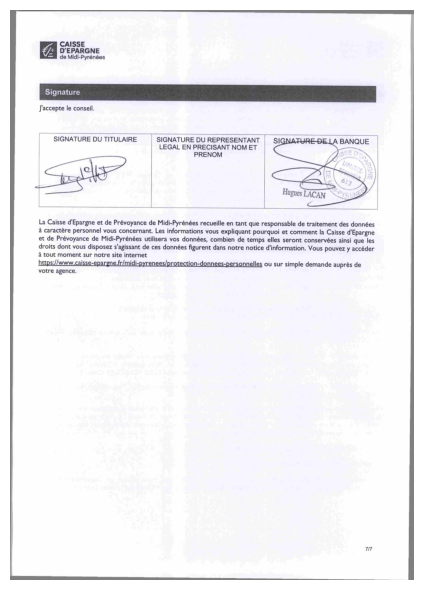

Image après rotation openCV :
angle openCV : 0.02866221847606629


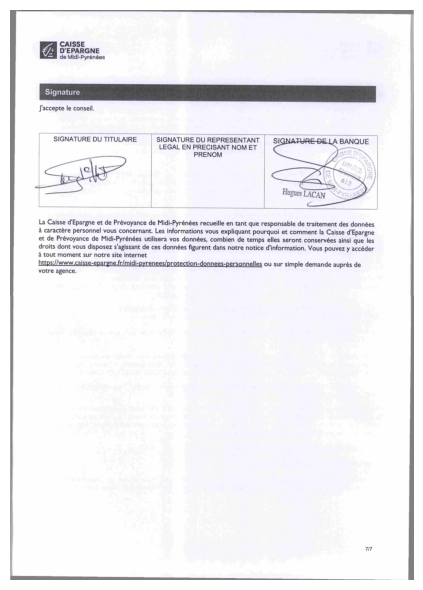

Image après pre-processing :


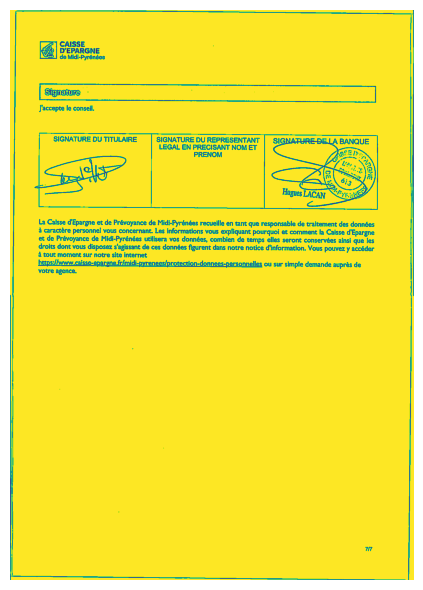

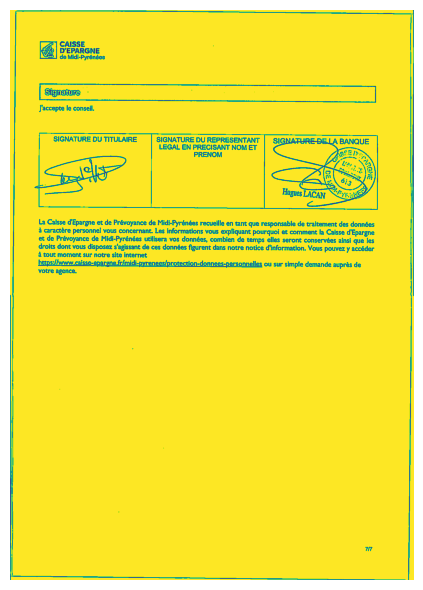

In [35]:
# liste de l'ensemble des mots clés à recherche pour identifier la page contenant la signature
keyWords = ["SIGNATURE", "SIGNATURE DU TITULAIRE", "SIGNATURE DU REPRESENTANT",  
            "SIGNATURE DE LA BANQUE",  "droits dont vous disposez", "J'accepte le conseil"]

im, image_info, warning = find_page_with_Tesseract_v0(pdf,keyWords,template_shape,verbose=True)
print("warning : ", warning)
show_image(im)

#### find_page_with_Tesseract() : avec calcul de similarité

In [36]:
def compute_strings_similarity(s1,s2):
    """
    Cette fonction permet de dire si deux chaînes de caractères 
    sont similaires. 
    
    Input:
    -----
    - s1, s2 (strings) : chaînes de caractères dont on veut 
      comparer la similarité
   
    Output:
    -------
    - similarity (float) : float entre 0 et 1 représentant la similarité de s1 et s2.
      Une valeur de 0 indique des documents très différents tandis qu'une valeur 
      de 1 indique des documents identiques.
    
    ================================== Notes ==================================
    La similarité ou indice de Jaccard, mesure la similarité entre deux ensembles. 
    Il est défini comme le rapport entre la taille de l'intersection des ensembles et 
    la taille de l'union des ensembles. En d'autres termes, il s'agit de la proportion 
    d'éléments communs entre deux ensembles.

    l'indice de Jaccard est particulièrement utile lorsque la présence ou l'absence d'éléments
    dans les ensembles est plus importante que leur fréquence ou leur ordre. 
    Par exemple, il peut être utilisé pour comparer la similarité de deux documents en considérant
    les ensembles de mots qui apparaissent dans chaque document.

    L'indice de Jaccard est calculé comme suit :
    J(A,B) = |A ∩ B| / |A ∪ B|

    où A et B sont des ensembles, et |A| et |B| représentent la cardinalité ou la taille des ensembles.

    L'indice de Jaccard est compris entre 0 et 1, où 0 indique qu'il n'y a pas d'éléments communs entre
    les ensembles, et 1 indique que les ensembles sont identiques.

    Dans notre cas, l'indice de Jacquart semble pertinent car l'OCR ne lit pas toujours les mots dans 
    le même sens selon les documents et nous souhaitons juste regarder si les deux textes présentent 
    les mêmes mots sans se soucier de leur position dans le texte.
    Au contraire des distances comme levenshtein (qui calcule la différence entre deux chaînes de caractères
    en comptant le nombre minimum d'insertions, de suppressions ou de substitutions d'un seul caractère nécessaires
    pour transformer une chaîne en une autre) ou la métrique SequenceMatcher de la librairie difflib (qui se base
    sur l'algorithme LCS consistant à trouver la plus longue sous-séquence "logique" présente dans les deux chaînes) 
    pour lesquelles la position des mots importe.
    ===========================================================================
    
    References:
    ----------
    - différentes méthodes pour calculer la similarité entre 2 textes:
     https://spotintelligence.com/2022/12/19/text-similarity-python/
    - python code pour jaccard-similarity
      https://studymachinelearning.com/jaccard-similarity-text-similarity-metric-in-nlp/
    """  
    # Retire les accents
    s1 = ''.join(c for c in unicodedata.normalize('NFD', s1) if unicodedata.category(c) != 'Mn')
    s2 = ''.join(c for c in unicodedata.normalize('NFD', s2) if unicodedata.category(c) != 'Mn')
    # Liste des mots uniques dans un document
    words_s1 = set(s1.lower().split())
    words_s2 = set(s2.lower().split())
    
    # Trouve l'intersection des listes de mots de s1 & s2
    intersection = words_s1.intersection(words_s2)

    # Trouve l'union des mots de la liste s1 & s2
    union = words_s1.union(words_s2)
        
    # Calcule le score de similarité de Jaccard 
    # en utilisant la longueur de l'ensemble d'intersection divisée
    # par la longueur de l'ensemble d'union. Float compris entre 0 et 1.
    similarity = float(len(intersection)) / len(union)
    
    return similarity

'''
def compute_strings_similarity(s1,s2,thresh=0.2):
    """
    Cette fonction permet de dire si deux chaînes de caractères 
    sont similaires. 
    
    Input:
    -----
    - s1, s2 (strings) : chaînes de caractères dont on veut 
      comparer la similarité
    - thresh (float) : seuil de similarité. Si la similarité 
      calculée est en dessous de ce seuil, alors les deux 
      châines de caractères s1 et s2 sont considérées 
      comme non similaires
    
    Output:
    -------
    - is_similar (bool) : Vaut True si s1 et s2 sont similaires.
    
    References:
    ----------
    - similarité entre 2 textes:
       https://stackoverflow.com/questions/53804735/get-similarity-percentage-on-multiple-strings
    - fonctionnement SequenceMatcher:
       https://towardsdatascience.com/sequencematcher-in-python-6b1e6f3915fc
       
    ========================== Notes ==========================
    Pour calculer la similarité entre deux textes, on utilise SequenceMatcher qui
    se base sur l'algorithme LCS.
    Étant donné deux chaînes de caractères, S1 et S2, l'idée consiste à trouver 
    la plus longue sous-séquence "logique" présente dans les deux chaînes (LCS) qui ne
    contient pas d'éléments "inutiles" (comme des espaces).
    "logique" ou "human readable" veut dire que SequenceMatcher trouve 
    une sous-séquence qui a du sens pour un être humain.
    ===========================================================
    """  
    # Calcul de la similarité entre s1 et s2
    # Renvoie un float entre 0 et 1
    similarity = SequenceMatcher(a=s1, b=s2).ratio()
    print("similarity:",similarity)
    
    if similarity > thresh:
        is_similar = True
    else : 
        is_similar = False
    return is_similar
'''

# Sélection de la page contenant la signature 
# ------------------------------------
def find_page_with_Tesseract(pdf,template_text,similarity_thresh=0.5,template_shape=(2338,1654),
                             start_with="end",verbose:bool=False):
    """
    Cette fonction permet de renvoyer la page du pdf dont le texte est le plus similaire
    à celui de template_text (= texte de la page template.)
    
    Si start_with="end", la recherche se fait en partant de la dernière page du pdf 
    et en remontant j'usqu'à la première page car la signature se trouve généralement
    à la fin du pdf. Si start_with="begin", la recherche se fait en partant de la 
    première page du pdf. Dès que la page est trouvée, la recherche s'arrête. 
    Avant de lire la page avec tesseract, une rotation de la page et un
    débruitage + seuillage de l'image sont appliqués dans le but d'améliorer
    la lecture.     
    
    Rq: Avant de calculer la position des mots, l'image à analyser est mise à la même
    échelle que l'image template. Ceci s'avère utile par la suite pour le calcul des 
    coordonées dans le cas où l'image à analyser n'aurait pas la même taille que l'image 
    template.
    
    >>> Utilise les fonctions get_angle_openCV(), get_angle_tesseract(), 
        rotate_im(), denoise_image() et compute_strings_similarity().
        Utilise la fonction show_image() si verbose=True.
        Pour davantage d'information, consulter la description de ces fonctions. 
    
     Input:
    ------
    - pdf (liste de PIL.PpmImagePlugin.PpmImageFile): ensemble des pages du pdf
    - template_text (string): texte contenu dans la page du pdf template;
      préalablement calculé avec la fonction read_page().
    - similarity_thresh (float) : seuil de similarité entre 2 textes. 
      Si la similarité calculée est en dessous de ce seuil, alors les deux textes ne sont
      pas similaires.
    - template_shape (tuple) : (height,width) ou (height,width,depth) taille de l'image
      ayant servi de template. Avant de calculer la position des mots, l'image à analyser
      est mise à la même échelle que l'image template. 
    - start_with (string) : peut prendre les valeurs "begin" et "end" et permet d'indiquer
      si on commence la recherche de la page contenant la signature en partant du début du 
      pdf (avec start_with="begin") ou de la fin du pdf (avec start_with="end"). 
    - verbose (bool): si True, affiche l'image aux différentes étapes de l'algorithme.
    
    Output:
    ------
    - final_im (np.array): image contenant au moins un des mots   
      clés de keyWords.    
    - image_info (dict): dictionnaire renvoyé par pytesseract.image_to_data()
      contenant toute l'information de la page. Ceci permet de réutiliser 
      image_info dans d'autres fonctions, sans avoir besoin de relire la page
      tesseract.
    - warning (bool): si True, aucun mot clé n'a été trouvé dans le pdf. 
      La dernière page du pdf sera alors retournée par défaut.
      
    Référence:
    ---------
    - transformation d'une image du format PIL.Image au format np.array :
      https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format
    """

    # ==========================================
    # Recherche de la page du pdf contenant au moins un des mots clés
    # ==========================================
    #si aucun mot clé n'est trouvé dans le texte, warning passera à True
    warning = False
    #boolean indiquant si on a trouvé ou non la page contenant la signature 
    found = False 
    
    # Pour être + rapide, on lit généralement les pages en partant de la fin (avec 
    # start_with="end") car la signature est généralement présente à la fin du pdf.
    # -------------------------------------
    if start_with=="end": #Si on commence la recherche de page par la fin du pdf
        i = len(pdf)-1 #compteur pour les pages du pdf.
        def condition(i): return i>-1 #fonction pour la boucle while
        increment = -1 #incrément
    elif start_with=="begin": #Si on commence la recherche de page par le début du pdf
        i = 0 #compteur pour les pages du pdf. 
        def condition(i): return i<len(pdf) #fonction pour la boucle while
        increment = 1 #incrément
    else:
        print("start_with doit être égal à 'end' ou 'begin'.")
    
    # I) Recherche des mots clés sur chaque page du pdf
    # -------------------------------------
    while not(found) and condition(i) :
        #page i du pdf
        im = pdf[i] 
        #Transformation de l'image du format PIL.Image au format np.array
        im = np.array(im)
        #Redimensionnement de l'image à la même taille que le template
        im = cv2.resize(im, (template_shape[1],template_shape[0]), interpolation = cv2.INTER_AREA)
        
        if verbose: #affichage de l'image si verbose=True
            print(">>> Fonction find_page_with_Tesseract() <<<")
            print("\nImage d'origine :")
            show_image(im)
        
        # 1) Rotation de l'image pour une meilleure lecture 
        # -------------------------------------
        # Etape 1 : rotation fine avec get_angle_openCV()
        angle1 = get_angle_openCV(im)
        if angle1 != 0:
            im = rotate_im(im,angle1)
            if verbose: #affichage de l'image si verbose=True
                print("Image après rotation openCV :")
                print("angle openCV :", angle1)
                show_image(im)
                
        # Etape 2 : rotation avec get_angle_tesseract() pour différencier entre 0° et 180°
        # si la page est blanche, tesseract lève une erreur. Dans ce cas, on ne lit pas la page.
        try:
            angle2 = get_angle_tesseract(im)
            if angle2 != 0:
                im = rotate_im(im,angle2)
                if verbose: #affichage de l'image si verbose=True
                    print("Image après rotation Tesseract :")
                    print("angle Tesseract :", angle2)
                    show_image(im)
        except pytesseract.TesseractError:
            pass
            
        # 2) Pre-processing de l'image pour améliorer la lecture
        # -------------------------------------
        im = denoise_image(im)
        if verbose: #affichage de l'image si verbose=True
            print("Image après pre-processing :")
            show_image(im)
        
        # 3) Extraction du texte de la page i avec tesseract
        # -------------------------------------
        results = pytesseract.image_to_data(im, output_type=pytesseract.Output.DICT)
        txt = ' '.join(results['text'])
        
        #calcule la similarité entre le texte de la page i du pdf 
        #et le texte du pdf template text_template.
        similarity = compute_strings_similarity(s1=template_text,s2=txt)
        
        if verbose : print("Similarity :", similarity)

        #si les textes sont similaires
        if similarity > similarity_thresh:
            found = True #on met found à true
            final_im = im #on récupère la page contenant la signature 
            image_info = results #on récupère les informations de la page
        #sinon, on passe à la page suivante
        else:
            i+=increment

    #II) Si après recherche de toutes les pages, aucun mot clé n'a été trouvé,
    #    le document est considéré comme une anomalie
    # -------------------------------------
    if found == False: 
        warning = True #anomalie
        final_im = pdf[-1] #la dernière page du pdf est retournée par défault.
        image_info = pytesseract.image_to_data(final_im, output_type=pytesseract.Output.DICT)
        
    return final_im, image_info, warning 

>>> Fonction find_page_with_Tesseract() <<<

Image d'origine :


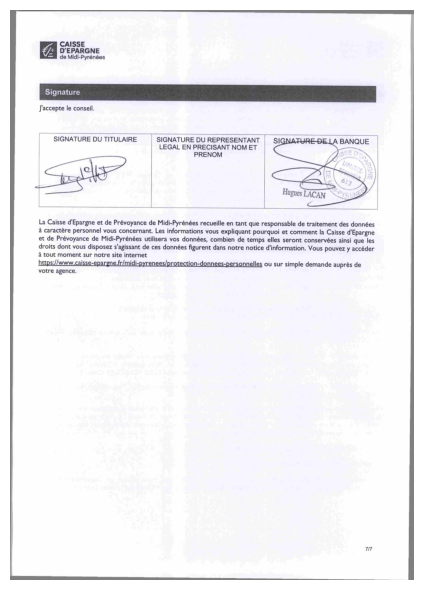

Image après rotation openCV :
angle openCV : 0.02866221847606629


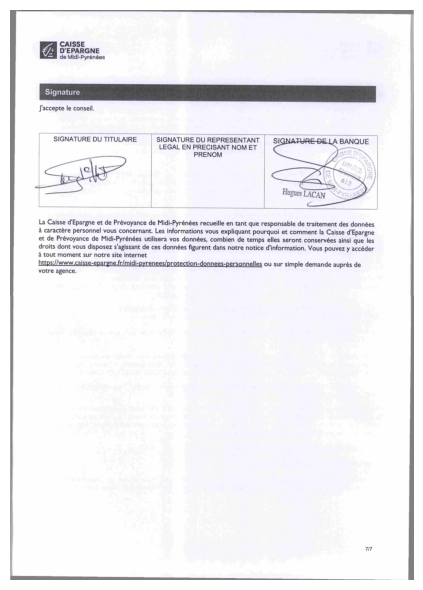

Image après pre-processing :


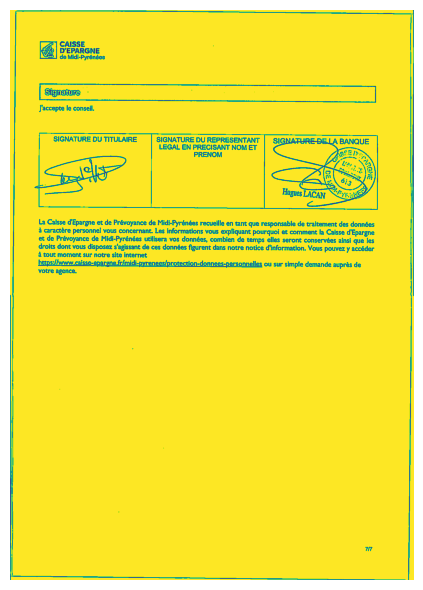

Similarity : 0.8641975308641975


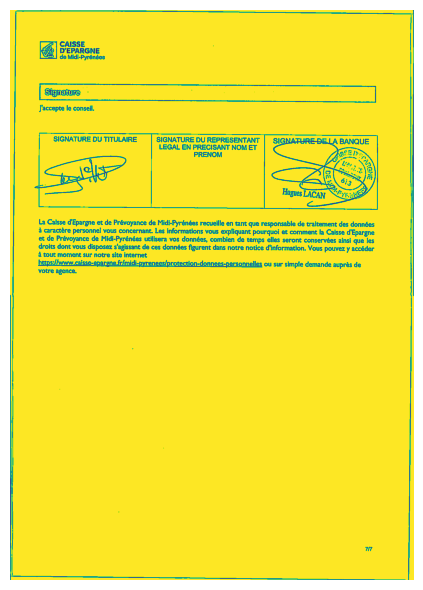

In [38]:
im, image_info, warning = find_page_with_Tesseract(pdf=pdf,
                                                   template_text=template_text,
                                                   similarity_thresh=0.5,
                                                   template_shape=template_shape,
                                                   start_with="end",
                                                   verbose=True)

print("warning : ", warning)
show_image(im)

#### find_1_keyWord_coord()

Que faire dans le cas où on ne peut pas détecter de mot clé ? L'argument warning est mis à True.
Comme on ne veut pas dire que le pdf est signé alors qu'il ne l'est pas, on mettra plutot un warning,
au lieu de chercher une autre méthode qui pourrait en fait dire que le pdf est signé.

In [39]:
def find_1_keyWord_coord(im, to_find, image_info=None, debug=False, min_conf=80):
    """
    Cette fonction recherche la première occurence 
    d'un des mots de la liste to_find sur l'image et renvoie sa position sur l'image.
    Si un mot de la liste n'est pas trouvé, on passe à la recherche du mot suivant, 
    sinon la recherche  s'arrête. La recherche se fait dans l'ordre des mots de to_find.
    Cette fonction utilise l'OCR Tesseract. 
    >>> utilise la fonction find_expression_in_list() 
    
    Pour davantage de détails, voir les Notes plus bas.

    Input:
    ------
    - im (np.array): image sur laquelle recherche les coordonées des mots clés.
    - to_find (list of string): liste des mots clés à rechercher. La recherche se fait
      dans l'ordre des mots de to_find. Dès qu'un mot est trouvé, on ne recherche pas les 
      mots suivants. Attention à ne pas mettre d'espace à la fin et au début des mots ou des 
      expressions. Ex : ['TITULAIRE','REPRESENTANT LEGAL','BANQUE'] 
    - image_info (dict) : information contenue dans l'image obtenue avec la fonction 
      pytesseract.image_to_data(). Si image_info=None, alors on lit la page pour en extraire
      l'information. Si image_info!=None, on ne lit pas la page et on utilise directement l'information
      contenue dans image_info.
    - debug (bool): si True, l'ensemble du texte détecté est affiché avec son niveau de confiance.
      Si un mot clé a été trouvé, l'image avec le mot clé encadré est également affichée.
    - min_conf (int): niveau de confiance minimale pour l'affichage du texte trouvé dans le cas 
      où debug=True.

    Output:
    -------
    - key_point (tuple de 2 int): coordonnées (x,y) du mot trouvé. Vaut (0,0)
      si aucun mot clé n'est trouvé.
    - keyWord (string): mot trouvé. 
    - wargning (bool): si True, aucun des mots de la liste to_find n'a pu être 
      détecté sur l'image. 

    References:
    ----------
    - détection de l'emplacement du texte avec Tesseract:
    https://pyimagesearch.com/2020/05/25/tesseract-ocr-text-localization-and-detection/

    - interprétation de la fonction image_to_data:
    https://stackoverflow.com/questions/61461520/does-anyone-knows-the-meaning-of-output-of-image-to-data-image-to-osd-methods-o

    ============================ Notes ============================
    Nous nous situons déjà sur la page contenant la signature.

    Nous cherchons à construire 2 cadres pour lesquels nous analyserons leur remplissage afin de déterminer
    si le pdf est signé ou non. Le 1er cadre concernera la signature du titulaire, si le 1er cadre n'est pas 
    rempli, nous irons voir le 2e cadre concernant la signature du représentant légal.

    Avec tesseract, on obtient une liste des mots trouvés dans le texte avec leur position correspondante.
    Les cadres seront donc déterminés en fonction de la position des mots clés sur la page. 

    Ainsi, nous contruisons une liste to_find = ['TITULAIRE','REPRESENTANT','BANQUE'] qui contient les mots
    clés que nous recherchons sur la page. A la première étape, l'algo cherche le premier mot clé 'TITULAIRE'. 
    Si ce mot est présent sur la page, on construit les 2 cadres en fonction des coordonnées de ce mot. 
    Si ce mot n'est pas trouvé, on passe au mot suivant 'REPRESENTANT' et on repète la procédure jusqu'à
    ce qu'un mot soit trouvé. 

    Cette méthode en plusieurs étapes permet davantage de robustesse dans le cas où l'OCR ne parviendrait
    pas à lire un des mots. 

    Rq: Normalement, l'OCR lit le texte ligne par ligne du haut vers le bas mais pas toujours !
    ==============================================================
    """

    #boolean pour dire si on a trouvé ou non un mot clé
    found = False
    #si on ne trouve aucun mot clé on a un warning
    warning = True
    #initialisation
    keyWord = ''
    #si ces valeurs ne sont pas mises à jour, aucun mot clé n'a été trouvé.
    key_point = (0,0)

    image = im.copy() 

    # ==============================================
    # Extraction des informations de l'image
    # ==============================================
    #extrcation de toutes les informations de l'image à l'aide de Tesseract
    if image_info: #si on a déjà récupéré au préalable les infos de la page 
        #liste de tous les mots trouvés par Tesseract
        Text = image_info["text"]
    else: #sinon, on lit la page pour en récupérer les infos
        image_info = pytesseract.image_to_data(im, output_type=pytesseract.Output.DICT)
        #liste de tous les mots trouvés par Tesseract
        Text = image_info["text"] 

    # ==============================================
    # L'algo cherche si le mot to_find[0] est présent dans le texte.
    # Si oui, on renvoie la position du mot to_find[0], 
    # sinon on passe au mot suivant fo_find[1] etc.
    # ==============================================
    i = 0 #compteur

    while not found and i<len(to_find) : #si i>=len(to_find), on aura un pb pour accéder à to_find[i]
        keyWord = to_find[i] 

        #indice du mot to_find[i] dans la liste Text
        # Méthode 1 avec np.where. Ne trouve que le mot exactement identique à 'TITULAIRE' par ex.
        #idx = np.where(np.array(Text) == keyWord)[0] 
        # Méthode 2 avec Regex. Peut trouver 'TITULAIRE' dans 'DUTITULAIREE'
        #idx = [j for j, item in enumerate(Text) if re.search(keyWord, item)]
        #-- Méthode 3 avec find_expression_in_list
        idx = find_expression_in_list(Text,keyWord)

        if idx!=None: #si on a trouvé le mot clé (ie idx n'est pas vide)
            found = True #on a trouvé un mot clé
            warning = False #on a pas de warning
            #idx = idx[0] 
            # (x,y) = positions du mot to_find[i]
            # le point d'origine (0,0) se trouve en haut à gauche du document 
            x = image_info["left"][idx] #abscisse du mot (point en haut à gauche)
            y = image_info["top"][idx] #ordonnée du mot (point en haut à gauche)
            key_point = (x,y)       
            
        else: #sinon, on passe à la recherche du mot suivant
            i+=1

    # ==============================================
    # Dans le cas où on a trouvé un mot,
    # on peut afficher le mot trouvé sur l'image pour debugging
    # ==============================================
    if debug : 
        print(">>> Fonction find_1_keyWord_coord() <<<")
        debug_text = [] #liste contenant tous les mots trouvés sur la page

        # loop over each of the individual text localizations
        for j in range(0, len(image_info["text"])):
            # extract the OCR text itself along with the confidence of the
            # text localization
            text = image_info["text"][j] #recognized text string
            conf = int(image_info["conf"][j]) #confidence of the detected text localization.

            # filter out weak confidence text localizations
            if conf > min_conf :
                # display the confidence and text to our terminal
                debug_text.append(text + " (conf:" + str(conf) + ")")         

        print("\n----- Texte trouvé avec un niveau de confiance >= " + str(min_conf) + " : -----")
        print(debug_text)
        
        # Affichage des mots trouvés
        if found:
            w = image_info["width"][idx] #hauteur du rectangle contenant le mot
            h = image_info["height"][idx] #largueur du rectangle contenant le mot
            # draw a bounding box around the text
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # draw the text 
            stripped_keyWord = ''.join(c for c in unicodedata.normalize('NFD', keyWord) if unicodedata.category(c) != 'Mn')
            cv2.putText(image, stripped_keyWord, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
        
        # display image
        print("\n----- Mot détecté sur l'image : -----")
        show_image(image)      
    # ==============================================

    return key_point, keyWord, warning

>>> Fonction find_1_keyWord_coord() <<<

----- Texte trouvé avec un niveau de confiance >= 80 : -----
['  (conf:95)', '  (conf:95)', '  (conf:95)', '  (conf:95)', '  (conf:95)', '  (conf:95)', '  (conf:95)', 'CAISSE (conf:92)', 'de (conf:96)', 'Midi-Pyrénées (conf:95)', '  (conf:95)', '  (conf:95)', '  (conf:95)', '  (conf:95)', '= (conf:84)', '  (conf:95)', 'le (conf:93)', 'conseil. (conf:83)', '  (conf:95)', 'SIGNATURE (conf:96)', 'DU (conf:93)', 'TITULAIRE (conf:92)', '  (conf:95)', '  (conf:95)', 'SIGNATURE (conf:96)', 'DU (conf:93)', 'REPRESENTANT (conf:92)', 'LEGAL (conf:96)', 'EN (conf:92)', 'PRECISANT (conf:92)', 'NOM (conf:96)', 'ET (conf:87)', 'PRENOM (conf:91)', '  (conf:95)', '  (conf:95)', '  (conf:95)', 'La (conf:96)', 'Caisse (conf:95)', "d'Epargne (conf:84)", 'et (conf:96)', 'de (conf:93)', 'Prévoyance (conf:92)', 'de (conf:96)', 'Midi-Pyrénées (conf:93)', 'recueille (conf:84)', 'en (conf:96)', 'tant (conf:96)', 'que (conf:96)', 'responsable (conf:96)', 'de (conf:95)', 

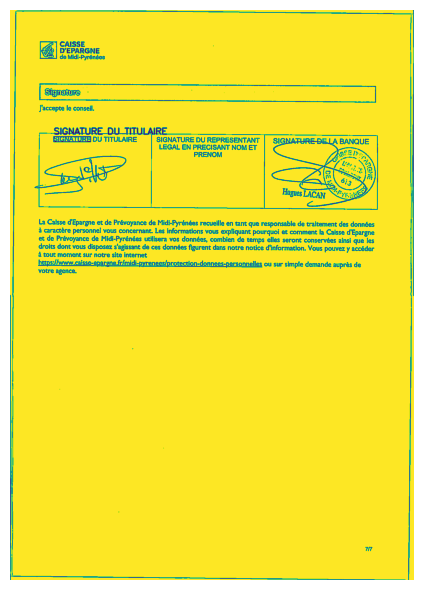

key_point :  (179, 519)
keyWord :  SIGNATURE DU TITULAIRE


In [40]:
to_find = ['SIGNATURE DU TITULAIRE','REPRESENTANT','BANQUE','CAISSE','Prévoyance']
#to_find = ['REPRESENTANT','BANQUE']
#to_find = ['BANQUE']
key_point, keyWord, warning = find_1_keyWord_coord(im, to_find, image_info, debug=True)
print("key_point : ",key_point)
print("keyWord : ",keyWord)
print("warning : ",warning)

#### extract_signature_boxes()

In [41]:
def extract_signature_boxes(im,key_point,keyWord,list_relative_points,debug:bool=False):
    """
    Cette fonction renvoie les images contenues dans les rectangles 
    dessinés au préalable par la fonction create_template().
    L'un des rectangles est supposé contenir une signature.
    
    Input:
    ------
    - im (np.array) : image contenant la signature
    - key_point (tuple) : coordonées (x,y) du mot clé renvoyé par la fonction 
      find_1_keyWord_coord()
    - keyWord (string) : mot clé renvoyé par la fonction 
      find_1_keyWord_coord()
    - list_relative_points (list de dict) : liste de dictionnaires où chaque dictionnaire
      représente les coordonnées d'un rectangle par rapport aux différents mots clés. 
      list_relative_points est renvoyé par la fonction compute_relative_coord().
    - debug (bool): si debug = True, les zones extraites sont affichées.
    
    Output:
    ------
    - list_im_boxes (list of np.array : liste d'images correspondant au contenu des différents
      rectangles. 
    """ 
    # liste contenant les images extraites. 
    list_im_boxes = [] 

    #parcourt des rectangles
    for i in range(len(list_relative_points)):
        # coordonées relatives du rectangle
        xr_relatif,yr_relatif,wr,hr = list_relative_points[i][keyWord]
        # coordonées du mot clé
        x,y = key_point

        # création de la boite : extrcation de l'image 
        im_box = im[y+yr_relatif:y+yr_relatif+hr, x+xr_relatif:x+xr_relatif+wr]
        # ajout de l'image à la liste d'images
        list_im_boxes.append(im_box)
        
    if debug: 
        print(">>> extract_signature_boxes() <<<")
        print("\n Zones de l'image extraites :")
        for im_box in list_im_boxes:
              show_image(im_box)        
        
    return list_im_boxes

>>> extract_signature_boxes() <<<

 Zones de l'image extraites :


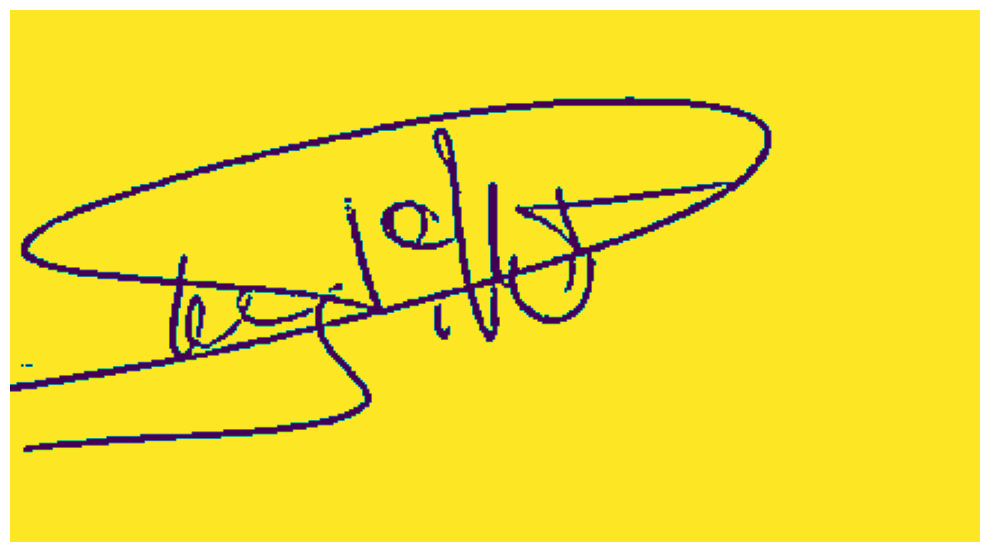

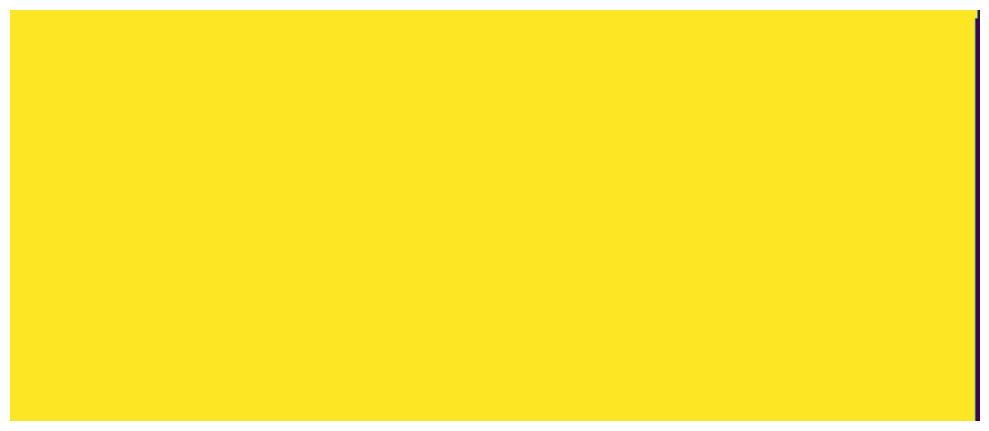

In [44]:
# Test de la fonction extract_signature()
#-------------------------------------------
list_im_boxes= extract_signature_boxes(im,key_point,keyWord,list_relative_points,debug=True)

#### verify_signature()

In [32]:
def verify_signature_v0(im_bin,
                    cropper_params = {"min_region_size":1e3,"border_ratio":0.01},
                    judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.01,1]},
                    verbose:bool=False):
    
    """
    Cette fonction permet de regrouper toutes les étapes nécessaires 
    pour détecter la signature sur un pdf scanné à l'aide de la librairie 
    signature-detect. L'image doit au préalable avoir été binarisée. 
    >>> Utilise la fonction show_image()
    
    Input:
    -----
    - im_bin (np.array): image binaire sur laquelle détecter la signature. 
      L'image devrait avoir été pre-processed auparavant.
    - cropper_params (dict): cropper_params = {"min_region_size":1e3,"border_ratio":0.01}
      Contient les paramètres du Cropper.
    - judger_params (dict): judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.01,1]}
      Contient les paramètres du Judger.
    - verbose (bool): si True, la description de l'Extractor, Cropper et Judger sont 
      affichés ainsi que des images. Affiche de plus les zones de pixels connectés trouvés 
      pour visualiser ce qu'il se passe.
    
    Ouput:
    ------
    - is_signed (bool): si True, le document est signé.
    
    ================================ Notes ================================
    La package signature-detect contient plusieurs modules résumés brièvement ici : 
    
    LOADER:
    Charge le pdf, le transforme en image et applique un pre-processing
    sur l'image pour obtenir une image binaire. 
    On n'utilise donc pas le Loader de signature-detect. On met en entrée
    une image déjà pre-processed par un équivalent du Loader que nous avons
    implémenté au préalable.

    EXTRACTOR:
    L'extractor enlève de l'image binaire les éléments qui sont trop grand ou trop petits pour 
    correspondre à une signature. Comme nous avons déjà extrait la portion de l'image supposée
    contenir la signature, nous n'utiliserons pas l'extractor. 

    CROPPER:
    Le cropper découpe l'image binaire selon des régions de pixels connectés. 
    Cette fonction est utile dans le cas où par exemple une image n'est pas 
    signée mais contient un bout de cadre. Si on utilise pas le cropper,
    le judger détectera que le bout de cadre est une signature. 

    JUDGER:
    Le judger lit les régions données par le cropper et applique plusieurs 
    critères de taille et de remplissage de la région pour déterminer si celle-ci 
    contient une signature.    
    =======================================================================
    
    Référence:
    ---------
    - tuto package signature-detect:
      https://github.com/EnzoSeason/signature_detection/blob/main/demo.ipynb
    """
    im = im_bin.copy()

    # =====================================
    # 1. CROPPER
    # =====================================
    # définition du Cropper
    cropper = Cropper(min_region_size=cropper_params["min_region_size"],
                      border_ratio= cropper_params["border_ratio"])
    # découpage de l'image selon des régions de pixels connectés
    results = cropper.run(im)

    # affichage si verbose=True
    if verbose: 
        print(">>> verify_signature() <<<")
        print(cropper)

    # =====================================
    # 2. JUDGER
    # =====================================
    # définition du Judger
    judger = Judger(size_ratio = judger_params["size_ratio"],
                    pixel_ratio = judger_params["pixel_ratio"],
                    debug = verbose)

    #----- si results contient une valeur, il peut y avoir une signature
    if len(results)>0:
        # la première valeur de results est la région de pixels
        # connectés la plus grande et est supposée correspondre
        # à la signature
        signature = results[0]["cropped_mask"]
        # le judger détermine si il y a signature 
        is_signed = judger.judge(signature)

        # affichage si verbose=True
        if verbose:
            print(">>> Image après Cropper:")
            show_image(signature)

    #----- si results ne contient aucune valeur, il n'y a pas de signature    
    else:
        is_signed = False

    # affichage si verbose=True
    if verbose: 
        print(judger)
        print(">>> Document signé:", is_signed)

    return is_signed

In [42]:
def verify_signature(im_bin,
                    cropper_params = {"min_region_size":1e3,"border_ratio":0.01},
                    judger_params = {"pixel_ratio": [0.01,1]},
                    verbose:bool=False):
    
    """
    Cette fonction permet de regrouper toutes les étapes nécessaires 
    pour détecter la signature sur un pdf scanné à l'aide de la librairie 
    signature-detect. L'image doit au préalable avoir été binarisée. 
    >>> Utilise la fonction show_image()
    
    Input:
    -----
    - im_bin (np.array): image binaire sur laquelle détecter la signature. 
      L'image devrait avoir été pre-processed auparavant.
    - cropper_params (dict): cropper_params = {"min_region_size":1e3,"border_ratio":0.01}
      Contient les paramètres du Cropper.
    - judger_params (dict): judger_params = {"pixel_ratio": [0.01,1]}
      Contient les paramètres du Judger.
    - verbose (bool): si True, la description de l'Extractor, Cropper et Judger sont 
      affichés ainsi que des images. Affiche de plus les zones de pixels connectés trouvés 
      pour visualiser ce qu'il se passe.
    
    Ouput:
    ------
    - is_signed (bool): si True, le document est signé.
    - signature (np.array): image de la signature extraite obtenue 
      après le Cropper. Si aucune signature n'a pu être détectée, signature=None. 
    
    ================================ Notes ================================
    La package signature-detect contient plusieurs modules résumés brièvement ici : 
    
    LOADER:
    Charge le pdf, le transforme en image et applique un pre-processing
    sur l'image pour obtenir une image binaire. 
    On n'utilise donc pas le Loader de signature-detect. On met en entrée
    une image déjà pre-processed par un équivalent du Loader que nous avons
    implémenté au préalable.

    EXTRACTOR:
    L'extractor enlève de l'image binaire les éléments qui sont trop grand ou trop petits pour 
    correspondre à une signature. Comme nous avons déjà extrait la portion de l'image supposée
    contenir la signature, nous n'utiliserons pas l'extractor. 

    CROPPER:
    Le cropper découpe l'image binaire selon des régions de pixels connectés. 
    Cette fonction est utile dans le cas où par exemple une image n'est pas 
    signée mais contient un bout de cadre. Si on utilise pas le cropper,
    le judger détectera que le bout de cadre est une signature. 

    JUDGER:
    Le judger lit les régions données par le cropper et applique plusieurs 
    critères de taille et de remplissage de la région pour déterminer si celle-ci 
    contient une signature.    
    =======================================================================
    
    Référence:
    ---------
    - tuto package signature-detect:
      https://github.com/EnzoSeason/signature_detection/blob/main/demo.ipynb
    """
    im = im_bin.copy()

    # =====================================
    # 1. CROPPER
    # =====================================
    # définition du Cropper
    cropper = Cropper(min_region_size=cropper_params["min_region_size"],
                      border_ratio= cropper_params["border_ratio"])
    # découpage de l'image selon des régions de pixels connectés
    results = cropper.run(im)

    # affichage si verbose=True
    if verbose: 
        print(">>> verify_signature() <<<")
        print(cropper)

    # =====================================
    # 2. JUDGER
    # =====================================
    # définition du Judger
    judger = Judger(pixel_ratio = judger_params["pixel_ratio"],
                    debug = verbose)

    #----- si results contient une valeur, il peut y avoir une signature
    if len(results)>0:
        # la première valeur de results est la région de pixels
        # connectés la plus grande et est supposée correspondre
        # à la signature
        signature = results[0]["cropped_mask"]
        # le judger détermine si il y a signature 
        is_signed = judger.judge(signature)

        # affichage si verbose=True
        if verbose:
            print(">>> Image après Cropper:")
            show_image(signature)

    #----- si results ne contient aucune valeur, il n'y a pas de signature    
    else:
        is_signed = False
        signature = None

    # affichage si verbose=True
    if verbose: 
        print(judger)
        print(">>> Document signé:", is_signed)

    return is_signed, signature


---------------- TEST SIGNATURE ----------------
>>> verify_signature() <<<

Cropper
min_region_size = 100.0
border_ratio = 0.01

pixel_ratio:  0.133775927900657
>>> Image après Cropper:


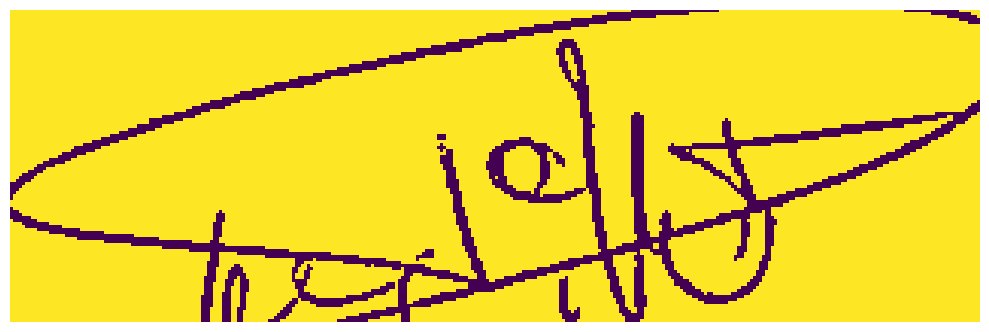


Judger
pixel_ratio = [0.001, 1]

>>> Document signé: True

---------------- TEST SIGNATURE ----------------
>>> verify_signature() <<<

Cropper
min_region_size = 100.0
border_ratio = 0.01


Judger
pixel_ratio = [0.001, 1]

>>> Document signé: False


In [45]:
for i in range(len(list_im_boxes)):
    im_box = list_im_boxes[i]
    print("\n---------------- TEST SIGNATURE ----------------")
    is_signed,signature = verify_signature(im_box,
                            cropper_params = {"min_region_size":1e2,"border_ratio":0.01},
                            judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.001,1]},
                            verbose = True)

#### check_signature_num()

In [46]:
import fitz
def check_signature_num(path_pdf):
    """
    Cette fonction permet de détecter si un document pdf numérique
    a été signé. 
    
    Input:
    -----
    - path_pdf (strig): chemin absolu vers le document pdf à vérifier.

    Ouput:
    ------
    - is_signed (bool): si True, le document a été signé.
    
    ================================ Notes ================================
    function get_sigflags(): PDF only: Return whether the document contains 
    signature fields. This is an optional PDF property: if not present (return value -1),
    no conclusions can be drawn – the PDF creator may just not have bothered using it.
    
    Returns
    -1: not a Form PDF / no signature fields recorded / no SigFlags found.
    1: at least one signature field exists.
    3: contains signatures that may be invalidated if the file is saved (written)
    in a way that alters its previous contents, as opposed to an incremental update.
    =======================================================================
    
    Reference:
    ---------
    - forum détection signature pdf:
      https://github.com/pymupdf/PyMuPDF/issues/326
    - fonction get_sigflags:
      https://pymupdf.readthedocs.io/en/latest/document.html#Document.get_sigflags
    """
    # ouvre le document
    doc = fitz.open(path_pdf) 
    # regarde si le document est signé
    sig = doc.get_sigflags()
    # ferme le document
    doc.close()
    # met à jour la variable is_signed
    if sig == -1:
        is_signed = False
    else:
        is_signed = True
    return is_signed

#### check_is_num()

In [53]:
def check_is_num(path_pdf):
    """
    Cette fonction permet de déterminer si un document pdf est numérique 
    ou scanné. 
    
    Input:
    -----
    - path_pdf (strig): chemin absolu vers le document pdf à vérifier.

    Ouput:
    ------
    - is_num (bool): si True, le document est numérique. Sinon, il est scanné.
    
    Reference:
    ---------
    - lecture d'un document avec fitz:
      https://pymupdf.readthedocs.io/en/latest/recipes-text.html
    """
    
    text = ""
    
    # ouverture du document
    doc = fitz.open(path_pdf)
    
    #On recherche une page pour laquelle on peut lire du texte.
    #Une fois la page trouvée, on arrête la recherche
    is_num=False
    i=0
    while not is_num and i<len(doc):
        page = doc[i]
        text += page.get_text(sort=True) #.encode("utf8") #encode return bytes
        if len(text)>0:
            is_num = True
        else:
            i+=1
            
    # ferme document
    doc.close()  
    
    return is_num

### Main()

Création d'un fichier main qui contient : le path des utilities, le path des données sur lesquelles effectuer 
la détection de sinature, le path du template. <font color = 'red'> Voir avec argparse ! Attention, il faudrait que dans le arparse on pense à mettre tous les paramètres que l'on peut modifier ! </font>

Créer plusieurs .py : un pour le pre-precessing, un pour le template, un pour l'extraction de signature. 

#### main_template()

In [35]:
### Fonction main, si on utilise pas le parser ###
def main_template(path_template:str, name_template:str, page_template:int,
                  keyWords_template, path_save_result:int=None, debug:bool=False,
                  show_instructions=True, windowHeight=None, windowWidth=None):
    """
    Cette fonction demande à l'utilisateur de définir le pdf template et de
    tracer sur ce pdf de référence les cadres supposés contenir la signature.
    
    Cette fonction : 
    - Charge le pdf servant de template.
    - Extrait la page du pdf template contenant la signature en renseignant un numéro de page.
    - Demande à l'utilisateur de tracer les rectangles supposés contenir la signature.
      Glisser déposer la souris sur l'image pour tracer les cadres. Appuyer sur "Echap" pour 
      annuler l'opération et ne pas enregistrer, "Enter" pour enregistrer les modifications
      et "Ctrl + z" pour revenir en arrière.
    - Trouve la position de tous les mots clés de la liste keyWords dans le template à l'aide de l'OCR Tesseract.
    - Calcule et renvoie les coordonnées relatives des rectangles par rapport à l'ensemble des mots clés. 
    
    >>> Utilise les fonctions load_pdf(), find_page_with_number()
        create_template(), find_all_keyWord_coord(), compute_relative_coord()
        et show_image().
        Pour d'avantage d'informations sur l'utilisation et le rôle de ces 
        fonctions, se référer à leur documentation. 
        
    Input:
    ------
    - path_template (string) : chemin du répertoire le pdf template. Ex: "C:/Users/A1234/data"
    - name_template (string) : nom du pdf template. Ex: "monpdf.pdf"
    - page_template (integer) : page du pdf template contenant la signature. 
      Attention, les pages commencent à l'indice 0. 
      Avec page_template=-1, la dernière page du pdf est renvoyée. 
    - keyWords_template (liste de strings) : liste contenant les mots clés à détecter dans la 
      page du pdf template.
    - path_save_result (string) : chemin du répertoire vers lequel sauvegarder la sortie de cette fonction.
      Si path_save=None, rien n'est sauvegardé. 
    - debug (boolean) : si True, des images et du texte sont affichés aux différentes étapes
      pour pouvoir mieux visualiser ce que fait la fonction.
    - show_instructions (boolean) : si True, une fenêtre contenant les instructions est affichée 
      lorsque l'utilisateur doit saisir le template.
    - windowHeight, windowWidth (int) : taille de l'image template à afficher à l'écran. 
      Si les deux valeurs sont à None, la taille de l'image est calculée 
      pour s'accomoder à la taille de l'écran d'ordinateur. 
      
    
    Output:
    ------
    - list_relative_points (liste de dictionnaire) : liste de dictionnaires où chaque dictionnaire
      représente les coordonnées d'un rectangle par rapport aux différents mots clés de keyWords_template. 
    - template_shape (tuple) : (height, width, depth) taille de l'image template.
    - template_text (string) : texte contenu dans la page du pdf template.
    """
    
    # 1) Chargement du pdf template
    pdf = load_pdf(name_template,path_template,poppler_path)

    # 2) Page du template contenant la signature
    im = find_page_with_number(pdf,page_template)
    template_shape = im.shape #taille de l'image template
    template_text = read_page(im) #texte de l'image template 
    

    #==============================
    if debug:
        print("Page sélectionnée : ")
        show_image(im)
    #==============================

    # 3) Demande à l'utilisateur de tracer les rectangles supposés contenir la signature
    box_prop_list,im_template = create_template(im,show_instructions=show_instructions,
                                                windowHeight=windowHeight,windowWidth=windowWidth)

    #==============================
    if debug:
        print("Template sélectionné :")
        show_image(im_template)
    #==============================

    # 4) Trouve la position de tous les mots clés dans le template
    key_points_dict = find_all_keyWord_coord(im, keyWords_template, debug=debug)

    # 5) Calcule les coordonnées relatives des rectangles par rapport à l'ensemble des mots clés
    list_relative_points = compute_relative_coord(box_prop_list,key_points_dict)
    
    # 6) Sauvegarde des coordonnées relatives, de la taille du template et du texte du template
    if path_save_result:
        with open(path_save_result + '/saved_template.pickle', 'wb') as handle:
            pickle.dump(list_relative_points, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        with open(path_save_result + '/template_shape.txt', 'w') as f:
            f.writelines(str(template_shape))
            
        with open(path_save_result + '/template_text.txt', 'w', encoding="utf-8") as f:
            f.writelines(template_text)
    
    return list_relative_points, template_shape, template_text

In [ ]:
list_relative_points, template_shape, template_text = main_template(
      path_template="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila/data/LEA/papier",
      name_template="006961477.pdf",
      page_template=-1, 
      path_save_result = "C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila",
      keyWords_template=['SIGNATURE DU TITULAIRE','REPRESENTANT','BANQUE','CAISSE', 'Prévoyance'],
      debug=False,
      show_instructions=True,
      windowHeight=None, 
      windowWidth=None)
#keyWords_template=['TITULAIRE','REPRESENTANT','BANQUE','CAISSE']

#### main_detectSignature()

##### version 0

In [ ]:
### Fonction main, si on utilise pas le parser ###
def drawProgressBar(percent, add_text='', barLen=20):
    """
    Affiche à l'écran une barre de progrès montrant l'avancement
    d'une fonction.
    
    Input:
    ------
    - percent (float) : pourcentage d'avancement entre 0 et 1.
    - add_text (string) : texte optionnel à ajouter à l'affichage
    - barLen (int) : longueur de la barre de progrès.
    
    Output:
    ------
    - Affichage de la barre de progrès à l'écran.
    
    Refrence:
    --------
    - https://stackoverflow.com/questions/3002085/how-to-print-out-status-bar-and-percentage
    """
    sys.stdout.write("\r")
    sys.stdout.write("[{:<{}}] {:.0f}%  {}".format("=" * int(barLen * percent), barLen, percent * 100, add_text))
    sys.stdout.flush()

def main_detectSignature_v0(path_data:str, keyWords_page:list, keyWords_template:list,path_save_result:str,                         
                         name_pdf:str=None, saved_template=None, template_shape=None, 
                         path_saved_template:str=None, debug = False,
                         cropper_params:dict={"min_region_size":1e2,"border_ratio":0.01},
                         judger_params:dict={"size_ratio":[1,4], "pixel_ratio": [0.001,1]}):
    
    
    """
    Cette fonction analyse des documents pdfs et détecte si ils sont signés.

    Cette fonction :
    - Charge les pdfs à vérifier
    - Charge les coordonnées du template sauvegardées au nom saved_template.pickle 
      ou utilise la valeur entrée en argument. 
      Pour chaque pdf : 
    - Détecte la page contenant la signature à l'aide de Tesseract
      en idendifiant les mots clés de la liste keyWords_page.
    - Calcule la position du premier mot de la liste keyWords_template trouvé sur la page.
    - Extrait les zones de l'image contenant la signature à l'aide de la position relative
      des cadres de saved_template par rapport aux coordonnées des mots de keyWords_page.
    - Parcourt de toutes les zones de l'image extraites et teste la présente de signature 
      pour chaque zone. Si au moins une zone contient une signature, le pdf est signé.    
    -  Sauvegarde le résultat.

    >>> Utilise les fonctions load_pdf(), find_page_with_Tesseract()
    find_1_keyWord_coord(), extract_signature_boxes(), verify_signature()
    et show_image().
    Pour d'avantage d'informations sur l'utilisation et le rôle de ces 
    fonctions, se référer à leur documentation.  

    Input:
    ------
    - path_data (string) : chemin du répertoire les pdf. Ex: "C:/Users/A1234/data"
    - name_pdf (string) : nom du pdf. Ex: "monpdf.pdf". 
      Si name_pdf=None, tout le répertoire indiqué par path_data est analysé.
    - keyWords_page (liste de strings) : liste de mots clés pour détecter
      quelle page du pdf contient la signature.    
    - keyWords_template (liste de strings) : liste contenant les mots clés à détecter dans la 
      page du pdf. Cette liste doit être identique à la liste keyWords_template sélectionnée dans 
      le template.
    - saved_template (liste de dictionnaire) : saved_template=list_relative_points. Liste de dictionnaires
      où chaque dictionnaire représente les coordonnées d'un rectangle par rapport aux différents mots 
      clés de keyWords_template. Si saved_template=None, alors le template sera récupéré dans le 
      répertoire indiqué par path_saved_template.
    - template_shape (tuple) : (height,width) ou (height,width,depth) taille de l'image
      ayant servi de template. Si template_shape=None, alors le template sera récupéré dans le répertoire
      indiqué par path_saved_template.
    - path_saved_template (string) : chemin du répertoire contenant la sauvegarde du template
      saved_template et la shape du template template_shape préalablement créés. 
    - path_save_result (string) : chemin du répertoire vers lequel sauvegarder la sortie de cette fonction.
      Si path_save_result=None, rien n'est sauvegardé. 
    - debug (boolean) : si True, des images et du texte sont affichés aux différentes étapes
      pour pouvoir mieux visualiser ce que fait la fonction. Lorsque qu'il y a trop d'images à analyser,
      il est déconseillé de mettre debug=True pour ne pas trop afficher. 
    - cropper_params = {"min_region_size":1e3,"border_ratio":0.01}. 
      Contient les paramètres du Cropper pour la fonction verify_signature(). 
    - judger_params (dict): judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.01,1]}
      Contient les paramètres du Judger pour la fonction verify_signature().

    Output:
    ------
    - result (dataframe) : dataframe contenant le résultat de l'analyse. Si path_save_result est 
      différent de None, la dataframe result est sauvegardée au chemin indiqué par path_save_result. 
    """

    if not(name_pdf): #si name_pdf=None, on analyse tout le répertoire donné par path_data
        directory = os.listdir(path_data)
    else: #sinon, on analyse seulement le pdf nommé par name_pdf
        directory = [name_pdf]

    # 0) Création de la dataframe de résultat
    result = pd.DataFrame() 

    print("Debut analyse...")
    # Parcourt de tous les pdf du répertoire
    #====== BEGIN for loop [
    j = 0
    for file_name in directory: 

        # 1) Affichage d'une barre de progression si debug=False
        if not(debug):
            drawProgressBar(percent=j/len(directory),add_text="file "+file_name)

        # 2) Chargement du pdf à vérifier
        pdf = load_pdf(file_name,path_data)

        # 3) Récupération des coordonnées relatives du template... 
        if not(saved_template):
            with open(path_saved_template + '/saved_template.pickle', 'rb') as handle:
                saved_template = pickle.load(handle)

        # ...et de la shape du pdf template
        if not(template_shape):
            with open(path_saved_template + '/template_shape.txt', encoding="utf-8") as f:
                template_shape = f.readlines()   

        # 4) Détection de la page contenant la signature 
        im, image_info, warning1 = find_page_with_Tesseract_v0(pdf,keyWords_page,verbose=debug)

        if warning1: #si la page n'a pas pu être détectée, on arrête l'analyse et on met un warning
            output_text = "Page contenant la signature non detectee"
        else: #sinon, on poursuit l'analyse

            # 5) Calcul de la position du premier mot de la liste keyWords_template trouvé sur la page
            key_point, keyWord, warning2 = find_1_keyWord_coord(im, keyWords_template, image_info, debug=debug)

            if warning2: #si les mots clés n'ont pas été trouvés, on arrête l'analyse et on met un warning
                output_text = "Mots cles pour identifier la position du cadre non detectes"
            else: #sinon, on poursuit l'analyse

                # 6) Extraction des zones de l'image contenant la signature 
                list_im_boxes = extract_signature_boxes(im,key_point,keyWord,saved_template,debug=debug)

                # 7) Parcourt de toutes les zones de l'image extraites et teste la présente de signature pour chaque zone.
                is_signed = [] 

                for i in range(len(list_im_boxes)): 
                    im_box = list_im_boxes[i]
                    res = verify_signature_v0(im_box,
                                           cropper_params = cropper_params,
                                           judger_params = judger_params,
                                           verbose = debug)
                    is_signed.append(res) 

                # Si au moins 1 rectangle contient une signature, le pdf est signé    
                if np.any(is_signed): 
                    output_text = "signature ok"
                else:
                    output_text = "no signature"

            # 8) Mise à jour de la dataframe résultat
            result = result.append({'file_name' : file_name, 'result' : output_text}, ignore_index = True)  
            j+=1
    #====== END for loop ]

    # Affichage d'une barre de progression si debug=False
    if not(debug):
        drawProgressBar(percent=j/len(directory), add_text='file '+ file_name)

    # 9) Sauvegarde du resultat
    if path_save_result :
        result.to_csv(path_save_result + "/result.csv")  

    print("\n...fin analyse !")
    
    return result

"""
result = main_detectSignature_v0(
path_data="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila/Alteryx/Workflow_LEA/input_data" ,
keyWords_page=["SIGNATURE", "SIGNATURE DU TITULAIRE", "SIGNATURE DU REPRESENTANT",  
               "SIGNATURE DE LA BANQUE",  "droits dont vous disposez", "J'accepte le conseil"], 
keyWords_template=['TITULAIRE','REPRESENTANT','BANQUE','CAISSE'],
path_save_result="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila",
name_pdf=None,  #"070960561.pdf"
saved_template=None,  #list_relative_points
template_shape=None, 
path_saved_template="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila",
debug = False,
cropper_params={"min_region_size":1e2,"border_ratio":0.01},
judger_params={"size_ratio":[1,4], "pixel_ratio": [0.001,1]})

"""

##### version 1

In [ ]:
### Fonction main, si on utilise pas le parser ###
def drawProgressBar(percent, add_text='', barLen=20):
    """
    Affiche à l'écran une barre de progrès montrant l'avancement
    d'une fonction.
    
    Input:
    ------
    - percent (float) : pourcentage d'avancement entre 0 et 1.
    - add_text (string) : texte optionnel à ajouter à l'affichage
    - barLen (int) : longueur de la barre de progrès.
    
    Output:
    ------
    - Affichage de la barre de progrès à l'écran.
    
    Refrence:
    --------
    - https://stackoverflow.com/questions/3002085/how-to-print-out-status-bar-and-percentage
    """
    sys.stdout.write("\r")
    sys.stdout.write("[{:<{}}] {:.0f}%  {}".format("=" * int(barLen * percent), barLen, percent * 100, add_text))
    sys.stdout.flush()
    
def sec2min(time):
    """
    Cette fonction prend en entrée un argument time en secondes
    et renvoie un tuple contenant la valeur de time en (minutes,secondes).
    """
    minutes = int(time//60) 
    secondes = round(time - minutes*60,3)
    return (minutes,secondes)

def main_detectSignature_v1(path_data:str, keyWords_template:list,path_save_result:str,                         
                         name_pdf:str=None, saved_template=None, template_shape=None, 
                         template_text=None,similarity_thresh=0.5,
                         path_saved_template:str=None, debug = False,
                         cropper_params:dict={"min_region_size":1e2,"border_ratio":0.01},
                         judger_params:dict={"size_ratio":[1,4], "pixel_ratio": [0.001,1]}):
    
    
    """
    Cette fonction analyse des documents pdfs et détecte si ils sont signés.

    Cette fonction :
    - Charge les pdfs à vérifier
    - Charge les coordonnées du template sauvegardées au nom saved_template.pickle 
      ou utilise la valeur entrée en argument. 
      Pour chaque pdf : 
    - Détecte la page contenant la signature à l'aide de Tesseract.
    - Calcule la position du premier mot de la liste keyWords_template trouvé sur la page.
    - Extrait les zones de l'image contenant la signature à l'aide de la position relative
      des cadres de saved_template par rapport aux coordonnées des mots de keyWords_template.
    - Parcourt de toutes les zones de l'image extraites et teste la présente de signature 
      pour chaque zone. Si au moins une zone contient une signature, le pdf est signé.    
    -  Sauvegarde le résultat.

    >>> Utilise les fonctions load_pdf(), find_page_with_Tesseract()
    find_1_keyWord_coord(), extract_signature_boxes(), verify_signature()
    et show_image().
    Pour d'avantage d'informations sur l'utilisation et le rôle de ces 
    fonctions, se référer à leur documentation.  

    Input:
    ------
    - path_data (string) : chemin du répertoire les pdf. Ex: "C:/Users/A1234/data"
    - name_pdf (string ou liste de string) : nom du pdf. Ex: "monpdf_1.pdf" OU 
      ["monpdf_1.pdf","monpdf_2.pdf"]. Si name_pdf=None, tout le répertoire indiqué 
      par path_data est analysé. 
    - keyWords_template (liste de strings) : liste contenant les mots clés à détecter dans la 
      page du pdf. Cette liste doit être identique à la liste keyWords_template sélectionnée dans 
      le template.
    - saved_template (liste de dictionnaire) : saved_template=list_relative_points. Liste de dictionnaires
      où chaque dictionnaire représente les coordonnées d'un rectangle supposé contenir la signature
      par rapport aux différents mots clés de keyWords_template. Si saved_template=None, alors le template
      sera récupéré dans le répertoire indiqué par path_saved_template.
    - template_shape (tuple) : (height,width) ou (height,width,depth) taille de l'image
      ayant servi de template. Si template_shape=None, alors template_shape sera récupéré dans le répertoire
      indiqué par path_saved_template.
    - template_text (string): texte contenu dans la page du pdf template. Si template_text=None,
      alors le texte sera récupéré dans le répertoire indiqué par path_saved_template.
    - similarity_thresh (float) : seuil de similarité entre 2 textes pour la fonction 
      find_page_with_Tesseract(). Si la similarité calculée est en dessous de ce seuil, 
      alors les deux textes ne sont pas similaires.
    - path_saved_template (string) : chemin du répertoire contenant la sauvegarde du template
      saved_template et la shape du template template_shape préalablement créés. 
    - path_save_result (string) : chemin du répertoire vers lequel sauvegarder la sortie de cette fonction.
      Si path_save_result=None, rien n'est sauvegardé. 
    - debug (boolean) : si True, des images et du texte sont affichés aux différentes étapes
      pour pouvoir mieux visualiser ce que fait la fonction. Lorsque qu'il y a trop d'images à analyser,
      il est déconseillé de mettre debug=True pour ne pas trop afficher. 
    - cropper_params = {"min_region_size":1e3,"border_ratio":0.01}. 
      Contient les paramètres du Cropper pour la fonction verify_signature(). 
    - judger_params (dict): judger_params = {"size_ratio":[1,4], "pixel_ratio": [0.01,1]}
      Contient les paramètres du Judger pour la fonction verify_signature().

    Output:
    ------
    - result (dataframe) : dataframe contenant le résultat de l'analyse. Si path_save_result est 
      différent de None, la dataframe result est sauvegardée au chemin indiqué par path_save_result. 
    """
    
    # Temps de départ
    st = time.time()

    if not(name_pdf): #si name_pdf=None, on analyse tout le répertoire donné par path_data
        directory = os.listdir(path_data)
    elif type(name_pdf)==str: #si name_pdf est un string, on analyse seulement le pdf nommé par name_pdf
        directory = [name_pdf]
    else: #sinon, cela veut dire que name_pdf est déjà une liste
        directory = name_pdf

    # 1) Récupération des coordonnées relatives du template... 
    if not(saved_template):
        with open(path_saved_template + '/saved_template.pickle', 'rb') as handle:
            saved_template = pickle.load(handle)

    # ...et de la shape du pdf template...
    if not(template_shape):
        with open(path_saved_template + '/template_shape.txt') as f:
            template_shape = f.read()  
        template_shape = eval(template_shape) #conversion str -> tuple
  
    # ...et du texte contenu dans le pdf template
    if not(template_text):
        with open(path_saved_template + '/template_text.txt') as f:
            template_text = f.read()  
    print(template_text)

    # 2) Création de la dataframe de résultat
    result = pd.DataFrame() 

    print("\nDebut analyse...")
    # Parcourt de tous les pdf du répertoire
    #====== BEGIN for loop [
    j = 0
    for file_name in directory:
        
        # 3) Affichage d'une barre de progression si debug=False
        if not(debug):
            drawProgressBar(percent=j/len(directory),add_text="file "+file_name)

        # 4) Chargement du pdf à vérifier
        pdf = load_pdf(file_name,path_data,poppler_path) 

        # 5) Détection de la page contenant la signature 
        im, image_info, warning1 = find_page_with_Tesseract(pdf=pdf,
                                                            template_text=template_text,
                                                            similarity_thresh=similarity_thresh,
                                                            template_shape=template_shape,
                                                            verbose=debug)

        if warning1: #si la page n'a pas pu être détectée, on arrête l'analyse et on met un warning
            output_text = "Page contenant la signature non detectee"
        else: #sinon, on poursuit l'analyse

            # 6) Calcul de la position du premier mot de la liste keyWords_template trouvé sur la page
            key_point, keyWord, warning2 = find_1_keyWord_coord(im,keyWords_template,image_info,debug)

            if warning2: #si les mots clés n'ont pas été trouvés, on arrête l'analyse et on met un warning
                output_text = "Mots cles pour identifier la position du cadre non detectes"
            else: #sinon, on poursuit l'analyse

                # 7) Extraction des zones de l'image contenant la signature 
                list_im_boxes = extract_signature_boxes(im,key_point,keyWord,saved_template,debug=debug)

                # 8) Parcourt de toutes les zones de l'image extraites et teste la présente de signature pour chaque zone.
                is_signed = [] 

                for i in range(len(list_im_boxes)): 
                    im_box = list_im_boxes[i]
                    res = verify_signature_v0(im_box,
                                           cropper_params = cropper_params,
                                           judger_params = judger_params,
                                           verbose = debug)
                    is_signed.append(res) 

                # Si au moins 1 rectangle contient une signature, le pdf est signé    
                if np.any(is_signed): 
                    output_text = "signature ok"
                else:
                    output_text = "no signature"
            
        # 9) Mise à jour de la dataframe résultat
        result = result.append({'file_name' : file_name, 'result' : output_text}, ignore_index = True)  
        j+=1

    #====== END for loop ]

    # Affichage de la fin de la barre de progression si debug=False
    if not(debug):
        drawProgressBar(percent=j/len(directory), add_text='file '+ file_name)

    # 10) Sauvegarde du resultat
    if path_save_result :
        result.to_csv(path_save_result + "/result.csv")  

    print("\n...fin analyse !")

    # Temps de fin
    et = time.time()
    # Temps d'exécution
    execution_time = et - st
    minutes,secondes = sec2min(execution_time)
    print("Temps d'exécution : {} minutes {} secondes".format(minutes,secondes))
    
    return result

In [ ]:
result = main_detectSignature_v1(
    path_data="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila/Alteryx/Workflow_LEA/input_data_small",
    keyWords_template=keyWords_template,
    path_save_result=None,
    name_pdf=None, 
    saved_template=list_relative_points,  #list_relative_points
    template_shape=template_shape, 
    similarity_thresh=0.5,
    template_text=template_text,
    path_saved_template=None,
    debug = True,
    cropper_params={"min_region_size":1e2,"border_ratio":0.01},
    judger_params={"size_ratio":[1,4], "pixel_ratio": [0.001,1]})

##### version 2

In [129]:
### Fonction main, si on utilise pas le parser ###
def drawProgressBar(percent, add_text='', barLen=20):
    """
    Affiche à l'écran une barre de progrès montrant l'avancement
    d'une fonction.
    
    Input:
    ------
    - percent (float) : pourcentage d'avancement entre 0 et 1.
    - add_text (string) : texte optionnel à ajouter à l'affichage
    - barLen (int) : longueur de la barre de progrès.
    
    Output:
    ------
    - Affichage de la barre de progrès à l'écran.
    
    Refrence:
    --------
    - https://stackoverflow.com/questions/3002085/how-to-print-out-status-bar-and-percentage
    """
    sys.stdout.write("\r")
    sys.stdout.write("[{:<{}}] {:.0f}%  {}".format("=" * int(barLen * percent), barLen, percent * 100, add_text))
    sys.stdout.flush()
    
def sec2min(time):
    """
    Cette fonction prend en entrée un argument time en secondes
    et renvoie un tuple contenant la valeur de time en (minutes,secondes).
    """
    minutes = int(time//60) 
    secondes = round(time - minutes*60,3)
    return (minutes,secondes)


import csv
import os 
import time
from pathlib import Path
from PIL import Image

def main_detectSignature_v2(path_data:str, keyWords_template:list, name_pdf:str=None,
                         saved_template=None,template_shape=None,template_text=None,path_saved_template:str=None,
                         path_save_result:str=None, path_save_imsig:str=None,                 
                         similarity_thresh:float=0.5, start_with="end", debug:bool = False,
                         cropper_params:dict={"min_region_size":1e2,"border_ratio":0.01},
                         judger_params:dict={"pixel_ratio": [0.001,1]}): #/!\ judger_params a changé    
    """
    Cette fonction analyse des documents pdfs et détecte si ils sont signés.

    Cette fonction :
    - Charge les pdfs à vérifier
    - Charge les coordonnées du template sauvegardées au nom saved_template.pickle 
      ou utilise la valeur entrée en argument. 
      Pour chaque pdf : 
    - Détecte la page contenant la signature à l'aide de Tesseract.
    - Calcule la position du premier mot de la liste keyWords_template trouvé sur la page.
    - Extrait les zones de l'image contenant la signature à l'aide de la position relative
      des cadres de saved_template par rapport aux coordonnées des mots de keyWords_template.
    - Parcourt de toutes les zones de l'image extraites et teste la présente de signature 
      pour chaque zone. Si au moins une zone contient une signature, le pdf est signé.    
    - Sauvegarde le résultat toutes les 10 itérations au chemin indiqué par path_save_result.
    - Si le fichier indiqué par path_save_result existe déjà, on reprend l'analyse des pdfs
      en analysant les pdfs qui se situent dans le répertoire path_data (ou indiqués par name_pdfs)
      mais qui ne sont pas dans le fichier indiqué par path_save_result. 

    >>> Utilise les fonctions load_pdf(), find_page_with_Tesseract()
    find_1_keyWord_coord(), extract_signature_boxes(), verify_signature()
    et show_image().
    Pour d'avantage d'informations sur l'utilisation et le rôle de ces 
    fonctions, se référer à leur documentation.  

    Input:
    ------
    - path_data (string) : chemin du répertoire des pdfs à analyser. Ex: path_data="C:/Users/A1234/data"
    
    - name_pdf (string, liste de string ou None) : nom du ou des pdfs à analyser. Ex: name_pdf="monpdf_1.pdf" 
      si on veut analyser 1 seul pdf OU name_pdf=["monpdf_1.pdf","monpdf_2.pdf"] pour plusieurs pdfs.
      Si name_pdf=None, tout le répertoire indiqué par path_data est analysé. 
      
    - keyWords_template (liste de strings) : liste contenant les mots clés à détecter dans la 
      page du pdf. Cette liste doit être identique à la liste keyWords_template sélectionnée dans 
      le template.
      
    - saved_template (liste de dictionnaire ou None) : saved_template=list_relative_points. Liste de 
      dictionnaires où chaque dictionnaire représente les coordonnées d'un rectangle supposé contenir 
      la signature par rapport aux différents mots clés de keyWords_template. Si saved_template=None,
      alors le template sera récupéré dans le répertoire indiqué par path_saved_template en
      chargeant le fichier "saved_template.pickle" prélablement créé par le module template.
      
    - template_shape (tuple ou None) : (height,width) ou (height,width,depth) taille de l'image
      ayant servi de template. Si template_shape=None, alors template_shape sera récupéré dans le répertoire
      indiqué par path_saved_template en chargeant le fichier "template_shape.txt" prélablement créé par le 
      module template.
      
    - template_text (string ou None): texte contenu dans la page du pdf template. 
      Si template_text=None, alors le texte sera récupéré dans le répertoire indiqué par 
      path_saved_template en chargeant le fichier "template_text.txt" prélablement créé 
      par le module template. 
      
    - path_saved_template (string ou None) : chemin du répertoire contenant la sauvegarde du template
      "saved_template.pickle", la shape du template "template_shape.txt" et le texte du 
      template "template_text.txt" préalablement créés par le module template. 
      Si path_saved_template=None, alors cela veut dire que l'on a renseigné les arguments
      saved_template, template_shape et template_text. 

    - path_save_result (string ou None) : chemin du fichier .csv vers lequel sauvegarder la sortie de cette
      fonction, Ex: path_save_result = "C:/Users/A1234/result/mon_resultat.csv". Si on a plus de 10 pdfs
      à analyser, la sauvegarde se fait tous les 10 pdfs. 
      Si path_save_result=None, rien n'est sauvegardé. 
      Si le fichier indiqué par path_save_result existe déjà, alors le code lit ce fichier et reprend 
      l'analyse des documents là où elle s'était précédemment arrêtée. Pour savoir à quel pdfs on s'était
      arrêtés lors de l'analyse précédente, on lit le fichier indiqué par path_save_result et on regarde 
      quels documents du répertoire path_data (ou quels document indiqués par name_pdf) ne sont 
      pas dans le fichier .csv. On analyse ces documents. 
      
    - path_save_imsig (string ou None) : chemin du répertoire où sauvegarder : 
      1) L'image du cadre supposé contenir la signature (avant Cropper).
         L'image est sauvegardée dans le répertoire path_save_imsig/before_cropper.
      2) L'image de la signature extraite par le Cropper dans le cadre supposé contenir 
         la signature (après le Cropper).  
         L'image est sauvegardée dans le répertoire path_save_imsig/after_cropper.
      Ex : path_save_imsig="C:\A0000\resultats_signatures" et path_save_imsig contient les 
      sous-répertoire before_cropper et after_cropper. 
      Si le répertoire path_save_imsig, before_cropper et after_cropper n'existent pas déjà, 
      il sont créés. Si path_save_sig=None, aucune image n'est sauvegardée.  
      Le nom des images est : "nomDuPDF_bci.jpg" où dans "bci", "i" est le numéro du cadre 
      supposé contenir la signature (il peut y avoir plusieurs cadres) et "bc" indique 
      que c'est une image "before cropper". "nomDuPDF_aci.jpg" indique une image "after cropper". 
      
    - similarity_thresh (float) : seuil de similarité entre 2 textes pour la fonction 
      find_page_with_Tesseract(). Si la similarité calculée est en dessous de ce seuil, 
      alors les deux textes ne sont pas similaires.
      
    - start_with (string) : peut prendre les valeurs "begin" et "end" et permet d'indiquer
      si on commence la recherche de la page contenant la signature en partant du début du 
      pdf (avec start_with="begin") ou de la fin du pdf (avec start_with="end"). 
      
    - debug (boolean) : si True, des images et du texte sont affichés aux différentes étapes
      pour pouvoir mieux visualiser ce que fait la fonction. Lorsque qu'il y a trop d'images à analyser,
      il est déconseillé de mettre debug=True pour ne pas trop afficher. 
      
    - cropper_params = {"min_region_size":1e3,"border_ratio":0.01}. 
      Contient les paramètres du Cropper pour la fonction verify_signature(). 
      
    - judger_params (dict): judger_params = {"pixel_ratio": [0.01,1]}
      Contient les paramètres du Judger pour la fonction verify_signature().

    Output:
    ------
    - result (dataframe) : dataframe contenant le résultat de l'analyse. Si path_save_result est 
      différent de None, la dataframe result est sauvegardée au chemin indiqué par path_save_result. 
    """

    # Temps de départ
    st = time.time()

    # ----------------------------
    # 1) Lecture des fichiers pdfs
    # ----------------------------
    if not(name_pdf): #si name_pdf=None, on analyse tout le répertoire donné par path_data
        directory = os.listdir(path_data)
    elif type(name_pdf)==str: #si name_pdf est un string, on analyse seulement le pdf nommé par name_pdf
        directory = [name_pdf]
    else: #sinon, cela veut dire que name_pdf est déjà une liste
        directory = name_pdf
    #utile pour drawProgressBar dans le cas où directory vide
    len_dir = len(directory)
    if len_dir==0: 
        file_name=''; len_dir=1; total_min=0; total_sec=0 
    
    # ----------------------------
    # 2) Récupération de saved_template, template_shape, template_text
    # ----------------------------
    # Récupération des coordonnées relatives du template... 
    if not(saved_template):
        with open(path_saved_template + '/saved_template.pickle', 'rb') as handle:
            saved_template = pickle.load(handle)

    # ...et de la shape du pdf template...
    if not(template_shape):
        with open(path_saved_template + '/template_shape.txt') as f:
            template_shape = f.read()  
        template_shape = eval(template_shape) #conversion str -> tuple
  
    # ...et du texte contenu dans le pdf template
    if not(template_text):
        with open(path_saved_template + '/template_text.txt', encoding="utf-8") as f:
            template_text = f.read()  

    # ----------------------------
    # 3) Création de la dataframe de résultat
    # ----------------------------        
    result = pd.DataFrame() 
    
    if path_save_result :
        # exist_file=True si le fichier indiqué par path_save_result existe déjà 
        exist_file = Path(path_save_result).is_file() 
        
        # ----------------------------  
        # 4.a) Création du fichier csv pour écrire le résultat 
        # si le fichier indiqué par path_save_result n'existe pas, on ne reprend pas les calculs de 
        # l'analyse précédente et donc on crée un nouveau fichier csv.
        # ----------------------------  
        if not(exist_file): # création du fichier csv
            print("Création du fichier",path_save_result)
            # création du fichier en mode lecture
            f = open(path_save_result, 'w', encoding='utf-8')
            # création du csv writer
            writer = csv.writer(f,delimiter=',') #csv.writer(f,delimiter=";") 
            # écriture de l'entête du fichier csv
            writer.writerow(['file_name','result','execution_time'])
            # fermeture du fichier 
            f.close()

        # ----------------------------
        # 4.b) Lecture du fichier csv pour écrire le résultat 
        # si fichier indiqué par path_save_result existe, alors on reprend les calcules précédents
        # là où on s'était arrêtés. 
        # ----------------------------
        else:
            print("Le fichier {} existe déjà. On reprend l'analyse à partir du dernier élément du fichier.".format(path_save_result))
            # récupération de l'information contenue dans le fichier indiqué par
            # path_save_result sous forme d'une dataframe
            result = pd.read_csv(path_save_result,delimiter=',')
            # on supprime de directory le nom des fichiers qui sont déjà dans result
            # pour ne pas analyser 2 fois les mêmes fichiers
            read_files = list(result["file_name"].values) #fichier lus dans le csv
            directory = list(set(directory).difference(set(read_files))) #nouveau directory
            #utile pour drawProgressBar dans le cas où directory vide
            len_dir = len(directory)
            if len_dir==0: 
                file_name=''; len_dir=1; total_min=0; total_sec=0

    print("\nDebut analyse...")
    
    # Parcourt de tous les pdf du répertoire
    #====== BEGIN for loop [
    j = 0
    for file_name in directory:
        
        # temps de début de l'itération
        st_it = time.time()

        # ----------------------------
        # 5) Affichage d'une barre de progression si debug=False
        # ----------------------------
        if not(debug):
            drawProgressBar(percent=j/len_dir,add_text="file "+file_name)
            
        if debug :
            print("\n**************************************")
            print("Fichier", file_name)
            print("**************************************")    
        # ----------------------------
        # 6) Chargement du pdf à vérifier
        # ----------------------------
        pdf = load_pdf(file_name,path_data,poppler_path) ####### 

        # ----------------------------
        # 7) Détection de la page contenant la signature 
        # ----------------------------
        im, image_info, warning1 = find_page_with_Tesseract(pdf=pdf,
                                                            template_text=template_text,
                                                            similarity_thresh=similarity_thresh,
                                                            template_shape=template_shape,
                                                            start_with=start_with,
                                                            verbose=debug)

        if warning1: #si la page n'a pas pu être détectée, on arrête l'analyse et on met un warning
            output_text = "Page contenant la signature non detectee"
        else: #sinon, on poursuit l'analyse

            # ----------------------------
            # 8) Calcul de la position du premier mot de la liste keyWords_template trouvé sur la page
            # ----------------------------
            key_point, keyWord, warning2 = find_1_keyWord_coord(im,keyWords_template,image_info,debug)

            if warning2: #si les mots clés n'ont pas été trouvés, on arrête l'analyse et on met un warning
                output_text = "Mots cles pour identifier la position du cadre non detectes"
            else: #sinon, on poursuit l'analyse

                # ----------------------------
                # 9) Extraction des zones de l'image contenant la signature 
                # ----------------------------
                list_im_boxes = extract_signature_boxes(im,key_point,keyWord,saved_template,debug=debug)

                # ----------------------------
                # 10) Parcourt de toutes les zones de l'image extraites et teste la présente de signature pour chaque zone.
                # ----------------------------
                is_signed = [] 

                for i in range(len(list_im_boxes)): 
                    im_box = list_im_boxes[i]
                    res, im_sig = verify_signature(im_box,
                                           cropper_params = cropper_params,
                                           judger_params = judger_params,
                                           verbose = debug)
                    is_signed.append(res) 
                    
                    # ----------------------------      
                    # 11) Sauvegarde de l'image "im_box" dans le cadre avant cropper 
                    # ET de l'image après crpper "res" et si path_save_sig!=None
                    # ----------------------------
                    if path_save_imsig and not (im_sig is None):
                        # Si le répertoire indiqué n'existe pas, on le crée
                        if not os.path.isdir(path_save_imsig): os.makedirs(path_save_imsig) 
                        # Création des répertoire before_cropper et after_cropper s'ils n'existent pas déjà 
                        if not os.path.isdir(path_save_imsig+'/before_cropper'):os.makedirs(path_save_imsig+'/before_cropper')
                        if not os.path.isdir(path_save_imsig+'/after_cropper'):os.makedirs(path_save_imsig+'/after_cropper')
                        # Sauvegarde des images dans les dossiers before_cropper et after_cropper
                        pil_im_sig = Image.fromarray(im_sig) #transformation de l'image au format pil
                        pil_im_box = Image.fromarray(im_box)
                        pil_im_sig.save(path_save_imsig+"/after_cropper/"+file_name[:-4]+"_ac"+str(i+1)+".jpg") #sauvegarde de l'image
                        pil_im_box.save(path_save_imsig+"/before_cropper/"+file_name[:-4]+"_bc"+str(i+1)+".jpg") 

                # Si au moins 1 rectangle contient une signature, le pdf est signé    
                if np.any(is_signed): 
                    output_text = "signature ok"
                else:
                    output_text = "no signature"
            
        # ----------------------------
        # 12) Calcul du temps d'exécution
        # ----------------------------
        et = time.time() #temps de l'itération
        
        it_execution_time = et - st_it #temps d'éxécution de l'itération 
        it_min,it_sec = sec2min(it_execution_time) #conversion en minutes et secondes
        
        total_execution_time = et - st #temps d'éxécution total depuis le début 
        total_min,total_sec = sec2min(total_execution_time) #conversion en minutes et secondes
        
        # ----------------------------
        # 13) Mise à jour de la dataframe résultat
        # ----------------------------
        result = result.append({'file_name' : file_name, 'result' : output_text, 
                                'pdf_execution_time': "{} min {} sec".format(it_min,it_sec),
                                'total_execution_time': "{} min {} sec".format(total_min,total_sec)},
                               ignore_index = True)  
        
        # ----------------------------
        # 14) Ecriture du résultat dans le fichier .csv
        # ----------------------------
        if path_save_result :
            # sauvegarde toutes les 10 itérations
            if j!=0 and j%10==0: # "if" à retirer si on veut sauvegarder à toutes les itérations
                result.to_csv(path_save_result,index=False) # Sauvegarde du résultat
                
                
        j+=1
    #====== END for loop ]
    
    # ----------------------------
    # 15) Zauvegarde finale dans tous les cas
    # (même si le nombre total d'itérartions est < 10)
    # ----------------------------
    if path_save_result :
        result.to_csv(path_save_result,index=False)

    # ----------------------------
    # 16) Affichage de la fin de la barre de progression si debug=False
    # ----------------------------
    if not(debug):
        drawProgressBar(percent=j/len_dir, add_text='file '+ file_name)

    # ----------------------------
    # 17) Affichage écran 
    # ----------------------------
    print("\n...fin analyse !")
    print("Temps d'exécution total: {} minutes {} secondes".format(total_min,total_sec))
    
    return result

##### version 3

In [51]:
### Fonction main, si on utilise pas le parser ###
def drawProgressBar(percent, add_text='', barLen=20):
    """
    Affiche à l'écran une barre de progrès montrant l'avancement
    d'une fonction.
    
    Input:
    ------
    - percent (float) : pourcentage d'avancement entre 0 et 1.
    - add_text (string) : texte optionnel à ajouter à l'affichage
    - barLen (int) : longueur de la barre de progrès.
    
    Output:
    ------
    - Affichage de la barre de progrès à l'écran.
    
    Refrence:
    --------
    - https://stackoverflow.com/questions/3002085/how-to-print-out-status-bar-and-percentage
    """
    sys.stdout.write("\r")
    sys.stdout.write("[{:<{}}] {:.0f}%  {}".format("=" * int(barLen * percent), barLen, percent * 100, add_text))
    sys.stdout.flush()
    
def sec2min(time):
    """
    Cette fonction prend en entrée un argument time en secondes
    et renvoie un tuple contenant la valeur de time en (minutes,secondes).
    """
    minutes = int(time//60) 
    secondes = round(time - minutes*60,3)
    return (minutes,secondes)


import csv
import os 
import time
from pathlib import Path
from PIL import Image
import fitz

def main_detectSignature(path_data:str, keyWords_template:list, name_pdf:str=None,
                         saved_template=None,template_shape=None,template_text=None,path_saved_template:str=None,
                         path_save_result:str=None, path_save_imsig:str=None,                 
                         similarity_thresh:float=0.5, start_with="end", debug:bool = False,
                         cropper_params:dict={"min_region_size":1e2,"border_ratio":0.01},
                         judger_params:dict={"pixel_ratio": [0.001,1]}): #/!\ judger_params a changé    
    """
    Cette fonction analyse des documents pdfs et détecte si ils sont signés.

    Cette fonction :
    - Charge les pdfs à vérifier
    - Charge les coordonnées du template sauvegardées au nom saved_template.pickle 
      ou utilise la valeur entrée en argument. 
      Pour chaque pdf : 
    - Détecte si le PDF est signé numériquement, sinon :
    - Détecte la page contenant la signature à l'aide de Tesseract.
    - Calcule la position du premier mot de la liste keyWords_template trouvé sur la page.
    - Extrait les zones de l'image contenant la signature à l'aide de la position relative
      des cadres de saved_template par rapport aux coordonnées des mots de keyWords_template.
    - Parcourt de toutes les zones de l'image extraites et teste la présente de signature 
      pour chaque zone. Si au moins une zone contient une signature, le pdf est signé.    
    - Sauvegarde le résultat toutes les 10 itérations au chemin indiqué par path_save_result.
    - Si le fichier indiqué par path_save_result existe déjà, on reprend l'analyse des pdfs
      en analysant les pdfs qui se situent dans le répertoire path_data (ou indiqués par name_pdfs)
      mais qui ne sont pas dans le fichier indiqué par path_save_result. 

    >>> Utilise les fonctions load_pdf(), find_page_with_Tesseract()
    find_1_keyWord_coord(), extract_signature_boxes(), verify_signature(), check_signature_num()
    et show_image().
    Pour d'avantage d'informations sur l'utilisation et le rôle de ces 
    fonctions, se référer à leur documentation.  

    Input:
    ------
    - path_data (string) : chemin du répertoire des pdfs à analyser. Ex: path_data="C:/Users/A1234/data"
    
    - name_pdf (string, liste de string ou None) : nom du ou des pdfs à analyser. Ex: name_pdf="monpdf_1.pdf" 
      si on veut analyser 1 seul pdf OU name_pdf=["monpdf_1.pdf","monpdf_2.pdf"] pour plusieurs pdfs.
      Si name_pdf=None, tout le répertoire indiqué par path_data est analysé. 
      
    - keyWords_template (liste de strings) : liste contenant les mots clés à détecter dans la 
      page du pdf. Cette liste doit être identique à la liste keyWords_template sélectionnée dans 
      le template.
      
    - saved_template (liste de dictionnaire ou None) : saved_template=list_relative_points. Liste de 
      dictionnaires où chaque dictionnaire représente les coordonnées d'un rectangle supposé contenir 
      la signature par rapport aux différents mots clés de keyWords_template. Si saved_template=None,
      alors le template sera récupéré dans le répertoire indiqué par path_saved_template en
      chargeant le fichier "saved_template.pickle" prélablement créé par le module template.
      
    - template_shape (tuple ou None) : (height,width) ou (height,width,depth) taille de l'image
      ayant servi de template. Si template_shape=None, alors template_shape sera récupéré dans le répertoire
      indiqué par path_saved_template en chargeant le fichier "template_shape.txt" prélablement créé par le 
      module template.
      
    - template_text (string ou None): texte contenu dans la page du pdf template. 
      Si template_text=None, alors le texte sera récupéré dans le répertoire indiqué par 
      path_saved_template en chargeant le fichier "template_text.txt" prélablement créé 
      par le module template. 
      
    - path_saved_template (string ou None) : chemin du répertoire contenant la sauvegarde du template
      "saved_template.pickle", la shape du template "template_shape.txt" et le texte du 
      template "template_text.txt" préalablement créés par le module template. 
      Si path_saved_template=None, alors cela veut dire que l'on a renseigné les arguments
      saved_template, template_shape et template_text. 

    - path_save_result (string ou None) : chemin du fichier .csv vers lequel sauvegarder la sortie de cette
      fonction, Ex: path_save_result = "C:/Users/A1234/result/mon_resultat.csv". Si on a plus de 10 pdfs
      à analyser, la sauvegarde se fait tous les 10 pdfs. 
      Si path_save_result=None, rien n'est sauvegardé. 
      Si le fichier indiqué par path_save_result existe déjà, alors le code lit ce fichier et reprend 
      l'analyse des documents là où elle s'était précédemment arrêtée. Pour savoir à quel pdfs on s'était
      arrêtés lors de l'analyse précédente, on lit le fichier indiqué par path_save_result et on regarde 
      quels documents du répertoire path_data (ou quels document indiqués par name_pdf) ne sont 
      pas dans le fichier .csv. On analyse ces documents. 
      
    - path_save_imsig (string ou None) : chemin du répertoire où sauvegarder : 
      1) L'image du cadre supposé contenir la signature (avant Cropper).
         L'image est sauvegardée dans le répertoire path_save_imsig/before_cropper.
      2) L'image de la signature extraite par le Cropper dans le cadre supposé contenir 
         la signature (après le Cropper).  
         L'image est sauvegardée dans le répertoire path_save_imsig/after_cropper.
      Ex : path_save_imsig="C:\A0000\resultats_signatures" et path_save_imsig contient les 
      sous-répertoire before_cropper et after_cropper. 
      Si le répertoire path_save_imsig, before_cropper et after_cropper n'existent pas déjà, 
      il sont créés. Si path_save_sig=None, aucune image n'est sauvegardée.  
      Le nom des images est : "nomDuPDF_bci.jpg" où dans "bci", "i" est le numéro du cadre 
      supposé contenir la signature (il peut y avoir plusieurs cadres) et "bc" indique 
      que c'est une image "before cropper". "nomDuPDF_aci.jpg" indique une image "after cropper". 
      
    - similarity_thresh (float) : seuil de similarité entre 2 textes pour la fonction 
      find_page_with_Tesseract(). Si la similarité calculée est en dessous de ce seuil, 
      alors les deux textes ne sont pas similaires.
      
    - start_with (string) : peut prendre les valeurs "begin" et "end" et permet d'indiquer
      si on commence la recherche de la page contenant la signature en partant du début du 
      pdf (avec start_with="begin") ou de la fin du pdf (avec start_with="end"). 
      
    - debug (boolean) : si True, des images et du texte sont affichés aux différentes étapes
      pour pouvoir mieux visualiser ce que fait la fonction. Lorsque qu'il y a trop d'images à analyser,
      il est déconseillé de mettre debug=True pour ne pas trop afficher. 
      
    - cropper_params = {"min_region_size":1e3,"border_ratio":0.01}. 
      Contient les paramètres du Cropper pour la fonction verify_signature(). 
      
    - judger_params (dict): judger_params = {"pixel_ratio": [0.01,1]}
      Contient les paramètres du Judger pour la fonction verify_signature().

    Output:
    ------
    - result (dataframe) : dataframe contenant le résultat de l'analyse. Si path_save_result est 
      différent de None, la dataframe result est sauvegardée au chemin indiqué par path_save_result. 
    """

    # Temps de départ
    st = time.time()

    # ----------------------------
    # 1) Lecture des fichiers pdfs
    # ----------------------------
    if not(name_pdf): #si name_pdf=None, on analyse tout le répertoire donné par path_data
        directory = os.listdir(path_data)
    elif type(name_pdf)==str: #si name_pdf est un string, on analyse seulement le pdf nommé par name_pdf
        directory = [name_pdf]
    else: #sinon, cela veut dire que name_pdf est déjà une liste
        directory = name_pdf
    #utile pour drawProgressBar dans le cas où directory vide
    len_dir = len(directory)
    if len_dir==0: 
        file_name=''; len_dir=1; total_min=0; total_sec=0 
    
    # ----------------------------
    # 2) Récupération de saved_template, template_shape, template_text
    # ----------------------------
    # Récupération des coordonnées relatives du template... 
    if not(saved_template):
        with open(path_saved_template + '/saved_template.pickle', 'rb') as handle:
            saved_template = pickle.load(handle)

    # ...et de la shape du pdf template...
    if not(template_shape):
        with open(path_saved_template + '/template_shape.txt') as f:
            template_shape = f.read()  
        template_shape = eval(template_shape) #conversion str -> tuple
  
    # ...et du texte contenu dans le pdf template
    if not(template_text):
        with open(path_saved_template + '/template_text.txt', encoding="utf-8") as f:
            template_text = f.read()  

    # ----------------------------
    # 3) Création de la dataframe de résultat
    # ----------------------------        
    result = pd.DataFrame() 
    
    if path_save_result :
        # exist_file=True si le fichier indiqué par path_save_result existe déjà 
        exist_file = Path(path_save_result).is_file() 
        
        # ----------------------------  
        # 4.a) Création du fichier csv pour écrire le résultat 
        # si le fichier indiqué par path_save_result n'existe pas, on ne reprend pas les calculs de 
        # l'analyse précédente et donc on crée un nouveau fichier csv.
        # ----------------------------  
        if not(exist_file): # création du fichier csv
            print("Création du fichier",path_save_result)
            # création du fichier en mode lecture
            f = open(path_save_result, 'w', encoding='utf-8')
            # création du csv writer
            writer = csv.writer(f,delimiter=',') #csv.writer(f,delimiter=";") 
            # écriture de l'entête du fichier csv
            writer.writerow(['file_name','result','execution_time'])
            # fermeture du fichier 
            f.close()

        # ----------------------------
        # 4.b) Lecture du fichier csv pour écrire le résultat 
        # si fichier indiqué par path_save_result existe, alors on reprend les calcules précédents
        # là où on s'était arrêtés. 
        # ----------------------------
        else:
            print("Le fichier {} existe déjà. On reprend l'analyse à partir du dernier élément du fichier.".format(path_save_result))
            # récupération de l'information contenue dans le fichier indiqué par
            # path_save_result sous forme d'une dataframe
            result = pd.read_csv(path_save_result,delimiter=',')
            # on supprime de directory le nom des fichiers qui sont déjà dans result
            # pour ne pas analyser 2 fois les mêmes fichiers
            read_files = list(result["file_name"].values) #fichier lus dans le csv
            directory = list(set(directory).difference(set(read_files))) #nouveau directory
            #utile pour drawProgressBar dans le cas où directory vide
            len_dir = len(directory)
            if len_dir==0: 
                file_name=''; len_dir=1; total_min=0; total_sec=0

    print("\nDebut analyse...")
    
    # Parcourt de tous les pdf du répertoire
    #====== BEGIN for loop [
    j = 0
    for file_name in directory:
        
        # temps de début de l'itération
        st_it = time.time()

        # ----------------------------
        # 5) Affichage d'une barre de progression si debug=False
        # ----------------------------
        if not(debug):
            drawProgressBar(percent=j/len_dir,add_text="file "+file_name)
            
        if debug :
            print("\n**************************************")
            print("Fichier", file_name)
            print("**************************************")    
        # ----------------------------
        # 6) Chargement du pdf à vérifier
        # ----------------------------
        pdf = load_pdf(file_name,path_data,poppler_path) ####### 

        # ----------------------------
        # 7) Détection de la présence d'une signature numérique
        # ----------------------------
        is_signed_num = check_signature_num(path_data+"/"+file_name) #le document est-il signé numériquement?
        
        if is_signed_num: #La signature est-elle numérique ?
            output_text = "signature numerique"
        
        else: #Sinon, la signature est peut-être papier
            
            # ----------------------------
            # 8) Détection de la page contenant la signature 
            # ----------------------------
            im, image_info, warning1 = find_page_with_Tesseract(pdf=pdf,
                                                                template_text=template_text,
                                                                similarity_thresh=similarity_thresh,
                                                                template_shape=template_shape,
                                                                start_with=start_with,
                                                                verbose=debug)

            if warning1: #si la page n'a pas pu être détectée, on arrête l'analyse et on met un warning
                output_text = "Page contenant la signature non detectee"
            else: #sinon, on poursuit l'analyse

                # ----------------------------
                # 9) Calcul de la position du premier mot de la liste keyWords_template trouvé sur la page
                # ----------------------------
                key_point, keyWord, warning2 = find_1_keyWord_coord(im,keyWords_template,image_info,debug)

                if warning2: #si les mots clés n'ont pas été trouvés, on arrête l'analyse et on met un warning
                    output_text = "Mots cles pour identifier la position du cadre non detectes"
                else: #sinon, on poursuit l'analyse

                    # ----------------------------
                    # 10) Extraction des zones de l'image contenant la signature 
                    # ----------------------------
                    list_im_boxes = extract_signature_boxes(im,key_point,keyWord,saved_template,debug=debug)

                    # ----------------------------
                    # 11) Parcourt de toutes les zones de l'image extraites et teste la présente de signature pour chaque zone.
                    # ----------------------------
                    is_signed = [] 

                    for i in range(len(list_im_boxes)): 
                        im_box = list_im_boxes[i]
                        res, im_sig = verify_signature(im_box,
                                               cropper_params = cropper_params,
                                               judger_params = judger_params,
                                               verbose = debug)
                        is_signed.append(res) 

                        # ----------------------------      
                        # 12) Sauvegarde de l'image "im_box" dans le cadre avant cropper 
                        # ET de l'image après crpper "res" et si path_save_sig!=None
                        # ----------------------------
                        if path_save_imsig and not (im_sig is None):
                            # Si le répertoire indiqué n'existe pas, on le crée
                            if not os.path.isdir(path_save_imsig): os.makedirs(path_save_imsig) 
                            # Création des répertoire before_cropper et after_cropper s'ils n'existent pas déjà 
                            if not os.path.isdir(path_save_imsig+'/before_cropper'):os.makedirs(path_save_imsig+'/before_cropper')
                            if not os.path.isdir(path_save_imsig+'/after_cropper'):os.makedirs(path_save_imsig+'/after_cropper')
                            # Sauvegarde des images dans les dossiers before_cropper et after_cropper
                            pil_im_sig = Image.fromarray(im_sig) #transformation de l'image au format pil
                            pil_im_box = Image.fromarray(im_box)
                            pil_im_sig.save(path_save_imsig+"/after_cropper/"+file_name[:-4]+"_ac"+str(i+1)+".jpg") #sauvegarde de l'image
                            pil_im_box.save(path_save_imsig+"/before_cropper/"+file_name[:-4]+"_bc"+str(i+1)+".jpg") 

                    # Si au moins 1 rectangle contient une signature, le pdf est signé    
                    if np.any(is_signed): 
                        output_text = "signature papier"
                    else:
                        output_text = "no signature"
            
        # ----------------------------
        # 13) Calcul du temps d'exécution
        # ----------------------------
        et = time.time() #temps de l'itération
        
        it_execution_time = et - st_it #temps d'éxécution de l'itération 
        it_min,it_sec = sec2min(it_execution_time) #conversion en minutes et secondes
        
        total_execution_time = et - st #temps d'éxécution total depuis le début 
        total_min,total_sec = sec2min(total_execution_time) #conversion en minutes et secondes
        
        # ----------------------------
        # 14) Mise à jour de la dataframe résultat
        # ----------------------------
        result = result.append({'file_name' : file_name, 'result' : output_text, 
                                'pdf_execution_time': "{} min {} sec".format(it_min,it_sec),
                                'total_execution_time': "{} min {} sec".format(total_min,total_sec)},
                               ignore_index = True)  
        
        # ----------------------------
        # 15) Ecriture du résultat dans le fichier .csv
        # ----------------------------
        if path_save_result :
            # sauvegarde toutes les 10 itérations
            if j!=0 and j%10==0: # "if" à retirer si on veut sauvegarder à toutes les itérations
                result.to_csv(path_save_result,index=False) # Sauvegarde du résultat
                
                
        j+=1
    #====== END for loop ]
    
    # ----------------------------
    # 16) Zauvegarde finale dans tous les cas
    # (même si le nombre total d'itérartions est < 10)
    # ----------------------------
    if path_save_result :
        result.to_csv(path_save_result,index=False)

    # ----------------------------
    # 17) Affichage de la fin de la barre de progression si debug=False
    # ----------------------------
    if not(debug):
        drawProgressBar(percent=j/len_dir, add_text='file '+ file_name)

    # ----------------------------
    # 18) Affichage écran 
    # ----------------------------
    print("\n...fin analyse !")
    print("Temps d'exécution total: {} minutes {} secondes".format(total_min,total_sec))
    
    return result

In [54]:
result = main_detectSignature(
    path_data="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila/Alteryx/Workflow_LEA/input_data",
    keyWords_template=keyWords_template,
    path_save_result="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/test3.csv",
    path_save_imsig=None, #"C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/imsig",
    name_pdf= None, 
    saved_template=list_relative_points,  #list_relative_points
    template_shape=template_shape, 
    similarity_thresh=0.5,
    template_text=template_text,
    path_saved_template=None,
    start_with="end",
    debug = False,
    cropper_params={"min_region_size":1e2,"border_ratio":0.01},
    judger_params={"size_ratio":[1,4], "pixel_ratio": [0.001,1]})

Le fichier C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/test3.csv existe déjà. On reprend l'analyse à partir du dernier élément du fichier.

Debut analyse...
[====================] 100%  file 007308023_sigTit_pap.pdf-01-21_ACQ13135-3100833-1642783931468-48718.pdf
...fin analyse !
Temps d'exécution total: 2 minutes 50.697 secondes


In [ ]:
result = main_detectSignature_v1(
    path_data="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila/Alteryx/Workflow_LEA/input_data",
    keyWords_template=['SIGNATURE DU TITULAIRE','REPRESENTANT','BANQUE','CAISSE', 'Prévoyance'],
    path_save_result="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila",
    name_pdf=["007308023_sigTit_pap.pdf",'007538249_sigTit_pap.pdf'], 
    saved_template=None,  #list_relative_points
    template_shape=None, 
    similarity_thresh=0.5,
    template_text=None,
    path_saved_template="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila/utilities",
    debug = False,
    cropper_params={"min_region_size":1e2,"border_ratio":0.01},
    judger_params={"size_ratio":[1,4], "pixel_ratio": [0.001,1]})

In [ ]:
'''result = main_detectSignature(
    path_data="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/Scans 2022-2023/All",
    keyWords_template=["Signature","Prenom","Fait à","DONNEES A CARACTERE PERSONNEL","DECLARATION DU CLIENT"],
    path_save_result=None,
    name_pdf="13135_007332173_CTEA_2022-03-10_ACQ13135-3177064-1646922710644-14228.pdf", 
    saved_template=list_relative_points,  #list_relative_points
    template_shape=template_shape, 
    similarity_thresh=0.5,
    template_text=template_text,
    path_saved_template="C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila/utilities",
    debug = True,
    cropper_params={"min_region_size":1e2,"border_ratio":0.01},
    judger_params={"size_ratio":[1,4], "pixel_ratio": [0.001,1]})'''

### retrieve_error_files()

In [1]:
def retrieve_error_files(csv_file,col1,col2,to_search,text_file):
    """
    Cette fonction prend en argument la table de résultats au format .csv indiquée par csv_file. 
    La table csv_file doit contenir au moins les colonnes col1 et col2 mais peut contenir d'autrces colonnes.
    La fonction crée en sortie un fichier .txt à l'endroit indiqué par text_file. 
    Le fichier .txt de sortie contient les éléments de col1 qui correspondant à la valeur to_search
    dans col2.
    Ex: csv_file = pd.DataFrame({'col1': ['file1', 'file2', 'file3', 'file4'],
                                 'col2': ['ok'   , 'ko'   ,    'ok', 'ko'   ]})
    si to_search='ko' alors text_file='file2 \n file3'.
    
    ========================================= Notes =========================================
    >>> A quoi sert cette fonction ?
    Admettons que nous ayons fait tourner le module detectSignature.py (avec run_detectSignature.py) 
    sur nos données avec un certain template défini au prélable par le module template.py (avec run_template.py).
    Nous avons sauvegardé le résultat dans un fichier .csv contenant les colonnes "file_name" (pour le nom des fichiers
    pdfs) et "result" (pour le résultat de la classification).
    Dans les résultat obtenus, nous lisons que certains pdfs ont été classés avec la mention
    "Page contenant la signature non detectee" dans la colonne "result". 
    Ceci peut être du au fait que ces pdfs ne correspondent pas au 1er template défini mais à un 2e template.
    Nous souhaitons donc faire utiliser run_detectSignature.py sur ces pdfs avec un 2e template.
    
    Pour répondre à la problématique ci-dessus, nous utilisons tout d'abord cette fonction pour trouver
    le nom des pdfs de la colonne "file_name" contenant la mention "Page contenant la signature non detectee" 
    dans la colonne "result". Pour ce faire, nous utilisons en argument col1="file_name", col2="result" et 
    to_search="Page contenant la signature non detectee". 
    Nous obtenons donc un fichier .txt avec les résultats de la recherche, par exemple intitulé "round2_files.txt".
    
    Ensuite, nous sélectionnons un 2e template avec run_template.py et nous faisons tourner run_detectSignature.py
    sur les pdfs indiqués dans le fichier "round2_files.txt" en mettant comme valeur pour la variable "path_name_pdf" 
    le chemin vers "round2_files.txt". 
    =========================================================================================
    
    
    Input:
    ------
    - csv_file (string) : chemin vers le fichier .csv pour lequel on veut lire le contenu.
      Ex : "C:/Users/A00000/result/my_file.csv"
      Le fichier .csv doit contenir au moins les colonnes indiquées par col1 et col2.
    - col1,col2 (string) : noms des colonnes du fichier .csv.
      Cette fonction recherche les éléments de col1 qui correspondant à la valeur to_search dans col2.
    - to_search (string) : string indiquant quelle valeur rechercher dans col_2
    - text_file (string) : chemin du fichier .txt contenant les résultats de la recherche. 
    
    Output:
    ------
    - match_list (list of string) : liste des éléments de col1 qui correspondant à la valeur 
      to_search dans col2.
    - enregistrement du fichier .txt à l'endroit indiqué par text_file.
    """
    # Lecture du fichier csv
    df_csv = pd.read_csv(csv_file) 
    # Recherche des éléments de col1 qui correspondant à la valeur to_search dans col2.
    match_list  = list(df_csv[col1].iloc[np.where(df_csv[col2]==to_search)].values)
    # Sauvegarde du résultat dans un fichier .txt
    with open(text_file, 'w', encoding="utf-8") as f:
        for item in match_list: # write each item on a new line
            f.write("%s\n" % item)
    return match_list

In [6]:
import pandas as pd
import numpy as np

In [7]:
match_list = retrieve_error_files(
    csv_file = "C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/1_Programme_Lila/result/Python/result_eai_type1.csv",
    col1 = 'file_name',
    col2 = 'result',
    to_search = "Page contenant la signature non detectee",
    text_file = "C:/Users/A3193307/Groupe BPCE/CEMP - Data & Décisionnel - Data Science/Analyse Documents/Scans 2022-2023/round2.txt"
)